In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/Gridworld/")
from Gridworld import Gridworld, GridBoard

# # 지도를 격자로 변환
---

## # 위도, 경도 <-> X, Y 좌표 변환 사용자 함수
---

In [ ]:
import math
NX = 149            ## X축 격자점 수
NY = 253            ## Y축 격자점 수

Re = 6371.00877     ##  지도반경
grid = 0.001         ##  격자간격 (km)
slat1 = 30.0        ##  표준위도 1
slat2 = 60.0        ##  표준위도 2
olon = 126.0        ##  기준점 경도
olat = 38.0         ##  기준점 위도
xo = 210 / grid     ##  기준점 X좌표
yo = 675 / grid     ##  기준점 Y좌표
# xo = 43 
# yo = 136
first = 0

if first == 0 :
    PI = math.asin(1.0) * 2.0
    DEGRAD = PI/ 180.0
    RADDEG = 180.0 / PI

    re = Re / grid
    slat1 = slat1 * DEGRAD
    slat2 = slat2 * DEGRAD
    olon = olon * DEGRAD
    olat = olat * DEGRAD

    sn = math.tan(PI * 0.25 + slat2 * 0.5) / math.tan(PI * 0.25 + slat1 * 0.5)
    sn = math.log(math.cos(slat1) / math.cos(slat2)) / math.log(sn)
    sf = math.tan(PI * 0.25 + slat1 * 0.5)
    sf = math.pow(sf, sn) * math.cos(slat1) / sn
    ro = math.tan(PI * 0.25 + olat * 0.5)
    ro = re * sf / math.pow(ro, sn)
    first = 1

def mapToGrid(lat, lon, code = 0 ):
    # ln = list_[0]
    # lat = list_[1]
    ra = math.tan(PI * 0.25 + lat * DEGRAD * 0.5)
    ra = re * sf / pow(ra, sn)
    theta = lon * DEGRAD - olon
    if theta > PI :
        theta -= 2.0 * PI
    if theta < -PI :
        theta += 2.0 * PI
    theta *= sn
    x = (ra * math.sin(theta)) + xo
    y = (ro - ra * math.cos(theta)) + yo
    x = int(x + 1.5)
    y = int(y + 1.5)
    return x, y

def gridToMap(x, y, code = 1):
    x = x - 1
    y = y - 1
    xn = x - xo
    yn = ro - y + yo
    ra = math.sqrt(xn * xn + yn * yn)
    if sn < 0.0 :
        ra = -ra
    alat = math.pow((re * sf / ra), (1.0 / sn))
    alat = 2.0 * math.atan(alat) - PI * 0.5
    if math.fabs(xn) <= 0.0 :
        theta = 0.0
    else :
        if math.fabs(yn) <= 0.0 :
            theta = PI * 0.5
            if xn < 0.0 :
                theta = -theta
        else :
            theta = math.atan2(xn, yn)
    alon = theta / sn + olon
    lat = alat * RADDEG
    lon = alon * RADDEG

    return lat, lon

print(mapToGrid(37.579871128849334, 126.98935225645432))
print(mapToGrid(35.101148844565955, 129.02478725562108))
print(mapToGrid(33.500946412305076, 126.54663058817043))
## result :
(60, 127)
(97, 74)
(53, 38)

print(gridToMap(60, 127))
print(gridToMap(97, 74))
print(gridToMap(53, 38))

(295001, 630001)
(480001, 365001)
(260001, 185001)
(31.795579194949102, 123.76185529502112)
(31.795108580706742, 123.76226532689546)
(31.794771415398294, 123.76180722317294)


# # DQN (Deep Q-learning Network)
---

## # 미로 찾기 1 (사용 안함)
---

In [ ]:
addMask('pit', '-', ())

In [ ]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [ ]:
class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Pit'].pos = (3,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid


    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()

In [ ]:
game = Gridworld(size = 10, mode = 'static')
game.display()

array([['+', ' ', ' ', 'P', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', 'W', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', '-', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:

import numpy as np

import torch

from Gridworld import Gridworld

import random

from matplotlib import pylab as plt

 

l1= 64 # 4X4X4

l2 = 150

l3 = 100

l4 = 4 #action

 

model = torch.nn.Sequential(

    torch.nn.Linear(l1,l2),

    torch.nn.ReLU(),

    torch.nn.Linear(l2,l3),

    torch.nn.ReLU(),

    torch.nn.Linear(l3,l4)

)

 

loss_fn = torch.nn.MSELoss()

learning_rate = 1e-3

optimizer  = torch.optim.Adam(model.parameters(),lr = learning_rate)

 

gamma = 0.9

epsilon = 1.0

 

action_set = {

    0: 'u',

    1: 'd',

    2: 'l',

    3: 'r',

}

 

epochs = 100

losses = [] #A

for i in range(epochs): #B

    game = Gridworld(size=4, mode='static') #C

    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #D

    state1 = torch.from_numpy(state_).float() #E

    status = 1 #F

    while(status == 1): #G

        qval = model(state1) #H

        qval_ = qval.data.numpy()

        if (random.random() < epsilon): #I

            action_ = np.random.randint(0,4)

        else:

            action_ = np.argmax(qval_)

        

        action = action_set[action_] #J

        game.makeMove(action) #K

        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0

        state2 = torch.from_numpy(state2_).float() #L

        reward = game.reward()

        with torch.no_grad():

            newQ = model(state2.reshape(1,64))

        maxQ = torch.max(newQ) #M

        if reward == -1: #N

            Y = reward + (gamma * maxQ)

        else:

            Y = reward

        Y = torch.Tensor([Y]).detach()

        X = qval.squeeze()[action_] #O

        loss = loss_fn(X, Y) #P

        print(i, loss.item())

       #clear_output(wait=True)

        optimizer.zero_grad()

        loss.backward()

        losses.append(loss.item())

        optimizer.step()

        state1 = state2

        if reward != -1: #Q

            status = 0

    if epsilon > 0.1: #R

        epsilon -= (1/epochs)

 

def test_model(model, mode='static', display=True):

    i = 0

    test_game = Gridworld(mode=mode)

    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0

    state = torch.from_numpy(state_).float()

    if display:

        print("Initial State:")

        print(test_game.display())

    status = 1

    while(status == 1): #A

        qval = model(state)

        qval_ = qval.data.numpy()

        action_ = np.argmax(qval_) #B

        action = action_set[action_]

        if display:

            print('Move #: %s; Taking action: %s' % (i, action))

        test_game.makeMove(action)

        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0

        state = torch.from_numpy(state_).float()

        if display:

            print(test_game.display())

        reward = test_game.reward()

        if reward != -1:

            if reward > 0:

                status = 2

                if display:

                    print("Game won! Reward: %s" % (reward,))

            else:

                status = 0

                if display:

                    print("Game LOST. Reward: %s" % (reward,))

        i += 1

        if (i > 15):

            if display:

                print("Game lost; too many moves.")

            break

    

    win = True if status == 2 else False

    return win

 

test_model(model)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 0.9941202998161316
0 0.9970187544822693
0 0.7443123459815979
0 0.7008640766143799
0 1.0097477436065674
0 1.0191160440444946
0 0.894612729549408
0 0.8485819697380066
0 0.8280817270278931
0 0.9972999691963196
0 0.704863429069519
0 0.9152095913887024
0 0.8118036985397339
0 0.9710589051246643
0 0.7396509051322937
0 0.9850639700889587
0 0.7321427464485168
0 0.7283651232719421
0 0.8998202085494995
0 0.9361807703971863
0 0.9600702524185181
0 0.6846605539321899
0 1.025092601776123
0 0.6438979506492615
0 0.6492166519165039
0 0.5940696001052856
0 0.592823326587677
0 0.6471853256225586
0 0.6023712158203125
0 0.5402055978775024
0 0.8219423890113831
0 0.4523422122001648
0 0.760164737701416
0 0.4160045087337494
0 0.302829384803772
0 0.6386669278144836
0 0.5361697673797607
0 0.14393514394760132
0 0.14119505882263184
0 0.9601105451583862
0 0.871856153011322
0 0.3042089343070984
0 0.21224749088287354
0 0.04688192158937454
0 0.14622941613197327
0 0.27399641275405884
0 0.08431320637464523
0 0.733677327

True

## # 미로 찾기 2
---

In [ ]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, PReLU, Conv2D, Input, Flatten
from tensorflow.keras.optimizers import SGD , Adam, RMSprop
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

In [ ]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

In [ ]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [ ]:
maze = [
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
]
maze = np.array(maze)

reward= -0.04


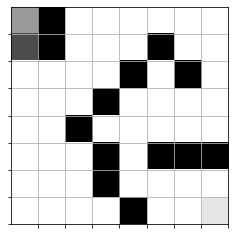

In [ ]:
qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)

print("reward=", reward)
show(qmaze)

In [ ]:
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])
        # action_word = {0: 'left', 1: 'up', 2: 'right', 3: 'down'}
        # print(action_word[action])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [ ]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

In [ ]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [ ]:
def qtrain(model, maze, **kwargs):
    global epsilon
    n_epoch = kwargs.get('epochs', 1000)
    max_memory = kwargs.get('max_memory', 1000)
    data_size = kwargs.get('data_size', 50)
    weights_file = kwargs.get('weights_file', "")
    name = kwargs.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1

    for epoch in range(0, n_epoch):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=4,
                # epochs=8, #기본
                batch_size=16, #기본
                # batch_size = 1024,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch+1, n_epoch, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [ ]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# def dqn_model(maze, lr = 0.001):
#     inputs = Input(shape=(maze.shape[0], maze.shape[1],1))
#     layer1 = Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='same')(inputs)
#     layer2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(layer1)
#     layer3 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(layer2)
#     layer4 = Flatten()(layer3)
#     predictions = Dense(num_actions, activation = PReLU())(layer4)
#     model = Model(inputs=inputs, outputs=predictions)
#     model.compile(optimizer='sgd',
#                   loss='mse',
#                   )
#     return model

In [ ]:
maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])
qmaze = Qmaze(maze)
# show(qmaze)

In [ ]:
maze_ = np.where(maze==0, 1, maze)
maze_

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

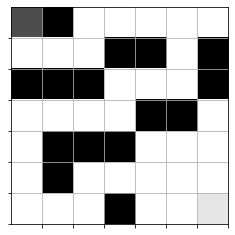

In [ ]:
qmaze = Qmaze(maze)
# plt.figure(figsize = (20, 10))
show(qmaze)

In [ ]:
model = build_model(maze)
# qtrain(model, maze_, epochs=1000, max_memory = 1*maze.size, data_size = 1)

In [ ]:
play_game(model, qmaze, (0, 0))

False

In [ ]:
show(qmaze)

In [ ]:
qmaze.visited

## # 미로 찾기 3 (사용 불가)
---

In [ ]:
'''
Maze Generation and Solving
Here we will generate and solve mazes. Mazes are generated as png images
using the Python Imaging Library (PIL), and similarly solved by reading in
a png image, and outputing a new one with the solution marked out in green.
*Note*************************************************************************
All coordinates of our maze are initialized as "0" to signify "Black". As
a new coordinate enters the positions stack, it will be come "1" to signify
"White".
******************************************************************************
*METHOD***********************************************************************
Visualization:
    https://en.wikipedia.org/wiki/File:Depth-First_Search_Animation.ogv
The approach taken in this lab is to use a "Depth First Search" approach at
maze generation and solving. This method starts with a "stack", let's call
this stack "positions". It will be initialized at some coordinate to signify
the start of the maze. As such, we may begin at:
    positions = [
        (0, 0)
    ]
We then will look for a valid position to take, and randomly select it.  Two
possibilities now exist:
    1. We take a random step.
    2. No valid options exist.
If (1), then we simply append the new coordinate to the positions stack,
adjust variables accordingly, and continue. If (2), then we "pop" the last
position out of the stack, and continue from where we previously were (seeking
out a new step to take). Note, this backtracking is represented in the
wikipedia example as the maze changing to blue.
Once the entire space of possible choices has been explored, it should be
evident that the backtracking will continue until the positions stack is
empty. It is at this point that the maze generation should end.
When solving, the same approach can be taken. Care needs to be made in
regards to assessing if a step is "valid" or not. Further, a new end criteria
needs making.
******************************************************************************
'''

class generate():
    import random
    from PIL import Image
    import os


    def get_colors():
        '''
        Colors map that the maze will use:
            0 - Black - A wall
            1 - White - A space to travel in the maze
            2 - Green - A valid solution of the maze
            3 - Red - A backtracked position during maze solving
            4 - Blue - Start and Endpoints of the maze
        **Returns**
            color_map: *dict, int, tuple*
                A dictionary that will correlate the integer key to
                a color.
        '''
        return {
            0: (0, 0, 0),
            1: (255, 255, 255),
            2: (0, 255, 0),
            3: (255, 0, 0),
            4: (0, 0, 255),
        }


    def save_maze(maze, blockSize, name, directory=os.getcwd()):
        '''
        This will save a maze object to a file.
        **Parameters**
            maze: *list, list, int*
                A list of lists, holding integers specifying the different aspects
                of the maze:
                    0 - Black - A wall
                    1 - White - A space to travel in the maze
                    2 - Green - A valid solution of the maze
                    3 - Red - A backtracked position during maze solving
                    4 - Blue - Start and Endpoints of the maze
            blockSize: *int, optional*
                How many pixels each block is comprised of.
            name: *str, optional*
                The name of the maze.png file to save.
            directory: *string*
                The location where the output file will be saved.
        **Returns**
            None
        '''
        nBlocks = len(maze)
        dims = nBlocks * blockSize
        colors = get_colors()
        # Verify that all values in the maze are valid colors.
        ERR_MSG = "Error, invalid maze value found!"
        assert all([x in colors.keys() for row in maze for x in row]), ERR_MSG
        img = Image.new("RGB", (dims, dims), color=0)
        # Parse "maze" into pixels
        for jx in range(nBlocks):
            for jy in range(nBlocks):
                x = jx * blockSize
                y = jy * blockSize
                for i in range(blockSize):
                    for j in range(blockSize):
                        img.putpixel((x + i, y + j), colors[maze[jx][jy]])
        if not name.endswith(".png"):
            name += ".png"
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.mkdir(directory)
        # Save the image in the proper directory
        output_string = directory + "/" + name
        img.save(output_string)


    def load_maze(filename, blockSize=10, directory=os.getcwd()):
        '''
        This will read a maze from a png file into a 2d list with values
        corresponding to the known color dictionary.
        **Parameters**
            filename: *str*
                The name of the maze.png file to load.
            blockSize: *int, optional*
                How many pixels each block is comprised of.
            directory: *string*
                The location where the output file will be saved.
        **Returns**
            maze: *list, list, int*
                A 2D array holding integers specifying each block's color.
        '''
        if ".png" in filename:
            filename = filename.split(".png")[0]
        img = Image.open(directory + "/" + filename + ".png")
        dims, _ = img.size
        nBlocks = int(dims / blockSize)
        colors = get_colors()
        color_map = {v: k for k, v in colors.items()}
        maze = [[0 for x in range(nBlocks)] for y in range(nBlocks)]
        for i, x in enumerate(range(0, dims, dims // nBlocks)):
            for j, y in enumerate(range(0, dims, dims // nBlocks)):
                px = x
                py = y
                maze[i][j] = color_map[img.getpixel((px, py))]
        return maze


    def pos_chk(x, y, nBlocks):
        '''
        Validate if the coordinates specified (x and y) are within the maze.
        **Parameters**
            x: *int*
                An x coordinate to check if it resides within the maze.
            y: *int*
                A y coordinate to check if it resides within the maze.
            nBlocks: *int*
                How many blocks wide the maze is.  Should be equivalent to
                the length of the maze (ie. len(maze)).
        **Returns**
            valid: *bool*
                Whether the coordiantes are valid (True) or not (False).
        '''
        return x >= 0 and x < nBlocks and y >= 0 and y < nBlocks


    def generate_maze(nBlocks, name, start, blockSize, slow,
                    directory=os.getcwd()):
        '''
        Generate a maze using the Depth First Search method.
        **Parameters**
            nBlocks: *int*
                The number of blocks in the maze (x and y dims are the same).
            name: *str, optional*
                The name of the output maze.png file.
            start: *tuple, int, optional*
                Where the maze will start from, and the initial direction.
            blockSize: *int, optional*
                How many pixels each block will be.
            slow: *bool, optional*
                Whether to save and lag on generation so as to view the mazegen.
            directory: *string*
                The location where the output file will be saved.
        **Returns**
            None
        '''
        # Initialize maze as an array of black cells
        maze = [[0 for i in range(nBlocks)] for j in range(nBlocks)]
        # Initialize stack of positions and directions
        positions = [start]
        list_of_directions = [0]
        # Define the four directions in which we can move
        directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]
        # Define the starting cell of the maze as white
        maze[start[0]][start[1]] = 1
        # Generate the maze
        while len(positions) > 0:
            # Retrieve the end values of the stacks
            current_x, current_y = positions[-1]
            current_d = list_of_directions[-1]
            # Prevent zigzags when generating the map
            if len(list_of_directions) > 2 and current_d != list_of_directions[-2]:
                d_range = [current_d]
            else:
                d_range = range(len(directions))
            # Initialize empty list for neighboring cells
            neighbors = []
            # Check neighboring cells for possible paths to take
            for i in d_range:
                # Define coordinates for next step
                next_x = current_x + directions[i][0]
                next_y = current_y + directions[i][1]
                # Check if specified coordinates are in the maze and if they
                # represent a wall
                if pos_chk(next_x, next_y, nBlocks) and maze[next_x][next_y] == 0:
                    # At this point, the number of occupied neighbors must be 1
                    count = 0
                    # Check if neighboring cells have adjacent paths and determine
                    # the possible paths to take
                    for j in range(len(directions)):
                        px = next_x + directions[j][0]
                        py = next_y + directions[j][1]
                        if pos_chk(px, py, nBlocks) and maze[px][py] == 1:
                            count += 1
                    if count == 1:
                        neighbors.append(i)
            # If 1 or more neighbors are available, then randomly select one and
            # move to it
            if len(neighbors) > 0:
                current_d = neighbors[random.randint(0, len(neighbors) - 1)]
                current_x += directions[current_d][0]
                current_y += directions[current_d][1]
                maze[current_x][current_y] = 1
                positions.append((current_x, current_y))
                list_of_directions.append(current_d)
            else:
                # If there are no possible neighboring cells to move to, remove
                # the current position from the stack
                positions.pop()
                list_of_directions.pop()
            if slow:
                save_maze(maze, blockSize=blockSize, name=name,
                        directory=directory)
        # Save the generated maze and set start/end points
        maze[0][0] = 1
        maze[nBlocks - 1][nBlocks - 1] = 1
        save_maze(maze, blockSize=blockSize, name=name, directory=directory)


    def solve_maze(filename, start, end, blockSize, slow, directory=os.getcwd()):
        '''
        Solve a maze using the Depth First Search method.
        **Parameters**
            filename: *str*
                The name of the maze.png file to be solved.
            start: *tuple, int, optional*
                Where the maze will start from.
            end: *tuple, int, optional*
                Where the maze will end.
            blockSize: *int, optional*
                How many pixels each block will be.
            slow: *bool, optional*
                Whether to save and lag on generation so as to view the mazegen.
            directory: *string*
                The location where the output file will be saved.
        **Returns**
            None
        '''
        # Remove file extension
        if ".png" in filename:
            filename = filename.split(".png")[0]
        # Load the maze
        maze = load_maze(filename, blockSize=blockSize, directory=directory)
        nBlocks = len(maze)
        # Initialize stack of positions
        positions = [start]
        # Define the four directions in which we can move
        directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]
        # Ensure that the start and end points are colored appropriately. If end
        # is not valid, this solver will fail!
        maze[start[0]][start[1]] = 4
        maze[end[0]][end[1]] = 4
        # Solve the maze
        while len(positions) > 0:
            # Retrieve the end values of the stack
            current_x, current_y = positions[-1]
            # Initialize empty list for neighboring cells
            neighbors = []
            # Determine which neighboring cells are possible to move to
            for i in range(len(directions)):
                # Define coordinates for next step
                next_x = current_x + directions[i][0]
                next_y = current_y + directions[i][1]
                # Check if specified coordinates are in the maze and if they
                # represent an available path to take
                if pos_chk(next_x, next_y, nBlocks) and (next_x, next_y) != start:
                    if maze[next_x][next_y] == 1 or maze[next_x][next_y] == 4:
                        neighbors.append(i)
            # If 1 or more neighbors are available, then randomly select one and
            # move to it
            if len(neighbors) > 0:
                current_d = neighbors[random.randint(0, len(neighbors) - 1)]
                current_x += directions[current_d][0]
                current_y += directions[current_d][1]
                # If we have reached the end of the maze, break out of the while
                # loop
                if (current_x, current_y) == end:
                    break
                # Set path to be green
                maze[current_x][current_y] = 2
                positions.append((current_x, current_y))
            else:
                # If there are no possible neighboring cells to move to, remove
                # the current position from the stack and backtrack
                maze[current_x][current_y] = 3
                positions.pop()
            if slow:
                save_maze(maze, blockSize=blockSize,
                        name="%s_solved.png" % filename, directory=directory)
        # Check if a solution has been found
        if not any([m == 2 for row in maze for m in row]):
            print("NO VALID SOLUTION FOR THE CHOSEN ENDPOINT!")
        # Save the solved maze
        save_maze(maze, blockSize=blockSize, name="%ss.png" % filename,
                directory=directory)


    if __name__ == "__main__":
        generate_maze(10, name="maze", start=(0, 0), blockSize=10, slow=False)

loading weights from file: model.h5
Epoch: 000/1 | Loss: 0.2082 | Episodes: 1 | Win count: 1 | Win rate: 0.000 | Time: 0.8 seconds
Epoch: 001/1 | Loss: 0.0018 | Episodes: 211 | Win count: 1 | Win rate: 0.000 | Time: 12.14 minutes
files: model.h5, model.json
n_epoch: 1, max_mem: 1000, data: 50, time: 12.14 minutes


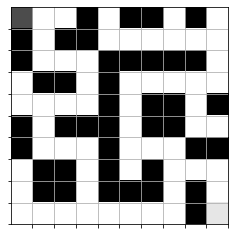

In [ ]:
'''
Train a neural network to solve a maze
Code and explanations adapted from https://samyzaf.com/ML/rl/qmaze.html
Introduction
------------------------------------------------------------------------------
This code uses deep reinforcement learning to solve a maze. Reinforcement
learning is a machine learning technique for solving problems by a feedback
system (rewards and penalties) applied on an agent which operates in an
environment and needs to move through a series of states in order to reach a
pre-defined final state. For example, an agent is trying to find the shortest
route from a starting cell to a target cell in a maze (environment). The agent
is experimenting and exploiting past experiences (episodes) in order to
achieve its goal. It may fail again and again, but hopefully, after lots of
trial and error (rewards and penalties) it will arrive to the solution of the
problem.
The solution will be reached if the agent finds the optimal sequence of states
in which the accumulated sum of rewards is maximal (in short, we lure the
agent to accumulate a maximal reward, and while doing so, it actually solves
our problem). Note that it may happen that in order to reach the goal, the
agent will have to endure many penalties (negative rewards) on its way. For
example, the agent in a maze gets a small penalty for every legal move. The
reason for that is that we want it to get to the target cell in the shortest
possible path. However, the shortest path to the target cell is sometimes long
and winding, and our agent may have to endure many penalties until it gets to
the target (sometimes called "delayed reward").
For this code, the target cell will always be the bottom-right corner of the
maze. The deep learning libraries used involve keras and TensorFlow. Matplotlb
is used to generate images.
Rewarding Scheme
------------------------------------------------------------------------------
Our rewards will be floats ranging from -1.0 to 1.0.
Each move from one state to the next state will be rewarded (the agent gets
points) by a positive or a negative (penalty) amount.
Each move from one cell to an adjacent cell will cost the agent -0.04 points.
This should discourage the agent from wandering around and get to the target
in the shortest route possible.
The maximal reward of 1.0 points is given when the agent reaches the target.
An attempt to enter a blocked cell will cost the agent -0.75 points! This is a
severe penalty, so hopefully the agent will learn to avoid it completely. Note
that an attempt to move to a blocked cell is invalid and will not be executed,
but it will incur a -0.75 penalty if attempted.
The same rule holds for an attempt to move outside the maze boundaries, with a
slightly higher penalty of -0.8 points.
The agent will be penalized by -0.25 points for any move to a cell which has
already been visited.
To avoid infinite loops and senseless wandering, the game is ended once the
total reward of the agent is below a negative threshold.
Q-learning
------------------------------------------------------------------------------
The main objective of Q-learning is to develop a policy for navigating the
maze successfully. Presumably, after playing hundreds of games, the agent
should attain a clear deterministic policy for how to act in every possible
situation.
The policy is a function that takes a maze snapshot (envstate) as input and
returns the action to be taken by the agent. The input consists of the full
maze state and the location of the agent.
At the start, we simply choose a completely random policy. Then we use it to
play thousands of games from which we learn how to perfect it. Surely, at the
early training stages, our policy will yield lots of errors and cause us to
lose many games, but our rewarding policy should provide feedback for it on
how to improve itself. The learning engine is going to be a simple
feed-forward neural network which takes an environment state as input and
yields a reward per action vector.
There are two types of moves in regard to Q-learning:
    Exploitation: these are moves that our policy dictates based on previous
                  experiences. The policy function is used in about 90% of the
                  moves before it is completed.
    Exploration: in about 10% of the cases, we take a completely random action
                 in order to acquire new experiences (and possibly meet bigger
                 rewards) which our strategy function may not allow us to make
                 due to its restrictive nature.
The exploration factor, epsilon, is the the frequency level of how much
exploration to do. It is usually set to 0.1, which roughly means that in one
of every 10 moves the agent takes a completely random action.
The policy function can be very difficult to find, especially for larger
environments. A common technique was to start with a different kind of
function, Q(s,a), called the best utility/quality function:
Q(s,a) = the maximum total reward we can get by choosing action a in state s
For maze solving, it is easy to be convinced that such function exists,
although we have no idea how to compute it efficiently (except for going
through all possible Markov chains that start at state s, which is very
inefficient). But it can also be proved mathematically for all similar Markov
systems. Our policy function will be:
pi(s) = argmax(Q(s,a_i))(i = 0,1,...,n-1)
We calculate Q(s,a_i) for all actions a_i, where i = 0,1,...,n−1 (where n is
the number of actions), and select the action a_i for which Q(s,a_i) is
maximal. We define Q(s,a) using Bellman's Equation, as shown below:
Q(s,a) = R(s,a) + max(Q(s',a_i))(i = 0,1,...,n-1), where s' is the transition
function and R is the reward function.
Training the Neural Network
------------------------------------------------------------------------------
The usual arrangement for training a neural network is to generate a
sufficiently large dataset of (e,q) pairs, where e is an environment state and
q = (q_0,q_1,...,q_n−1) are the correct actions (q-values). To do this, we
will have to simulate thousands of games and make sure that all our moves are
optimal (or else our q-values may not be correct). However, this approach is
impractical.
Here, we try a more practical and surprisingly elegant scheme for tackling
this problem. The scheme is as follows:
1. We will generate our training samples from using the neural network itself,
   by simulating hundreds or thousands of games. We will exploit the derived
   policy, pi, to make 90% of our game moves (the other 10% of the moves are
   reserved for exploration). However, we will set the target function of our
   neural network to be the function in the right side of Bellman's equation.
   Assuming that our neural network converges, it will define a function
   Q(s,a) which satisfies Bellman's equation, and therefore it must be the
   best utility function which we seek.
2. The training of the network, N, will be done after each game move by
   injecting a random selection of the most recent training samples to N.
   Assuming that our game skill will get better in time, we will use only a
   small number of the most recent training samples. We will forget old
   samples (which are probably bad) and will delete them from memory.
3. After each game move we will generate an episode and save it to a short
   term memory sequence. An episode is a tuple of 5 elements that we need for
   one training:
    episode = [envstate, action, reward, envstate_next, game_over]:
        envstate - environment state. This is a full picture of the maze cells
                   (the state of each cell including agent and target
                   location).To make it easier for our neural network, we
                   squash the maze to a 1-dimensional vector that fits the
                   network input.
        action - one of the four actions that the agent can move.
        reward - the reward received from the action.
        envstate_next - the new maze environment state which resulted from the
                        last action.
        game_over - a boolean value which indicates if the game is over or
                    not. The game is over if the agent has reached the target,
                    or if the agent has reached the negative reward limit
                    (lose).
After each move in the game, we form the episode and insert it into our memory
sequence. In case our memory sequence size grows beyond a fixed bound we
delete elements from its tail to keep it below this bound.
The weights of network N are initialized with random values, so in the
beginning N will produce awful results, but if our model parameters are chosen
properly, it should converge to a solution of the Bellman Equation, and
therefore later experiments are expected to be more truthful. Currently,
building a model that converges quickly seems to be very difficult and there is
still lots of room for improvement.
'''
import datetime
import json
import random
import numpy as np
import matplotlib.pyplot as plt
# import generate
# from keras.models import Sequential
# from keras.layers.core import Dense
# from keras.layers.advanced_activations import PReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, PReLU
from tensorflow.keras.optimizers import SGD , Adam, RMSprop
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


def get_actions():
    '''
    Dictionary reprenting possible actions to take in the maze.
    **Returns**
        action_map: *dict, int, str*
            A dictionary that will correlate the integer key to
            a possible action.
    '''
    # Define actions
    LEFT = 0
    UP = 1
    RIGHT = 2
    DOWN = 3
    # Return the dictionary of possible actions
    return {
        LEFT: 'left',
        UP: 'up',
        RIGHT: 'right',
        DOWN: 'down',
    }


class Qmaze(object):
    '''
    Class object for representing the maze in the context of Q-learning.
    **Parameters**
        maze: *list, list, floats* or *numpy array*
            A data structure that represents valid paths, walls, and current
            positions.
        pos: *tuple, int*
            The current position of the pointer.
    '''

    def __init__(self, maze, pos=(0, 0)):
        # Save maze as a NumPy array if it is not already a NumPy array
        self.maze = np.array(maze)
        # Define the target position
        nrows, ncols = self.maze.shape
        self.target = (nrows - 1, ncols - 1)
        # Define valid paths
        self.paths = [(r, c) for r in range(nrows)
                      for c in range(ncols) if self.maze[r, c] == 1.0]
        # Checks for if a maze is valid or not
        if self.maze[self.target] == 0.0:
            raise Exception("Invalid Maze: target cell cannot be blocked!")
        if pos not in self.paths:
            raise Exception("Invalid Location")
        # Remove the target position from the list of valid paths
        self.paths.remove(self.target)
        # Call reset function during initialization
        self.reset(pos)

    def reset(self, pos):
        '''
        Reset the pointer to a given position and update appropriate
        variables.
        '''
        self.pos = pos
        self.maze = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        row, col = pos
        # Set maze position
        self.maze[row, col] = 0.5
        self.state = (row, col, 'start')
        # Define the minimum reward and initialize total reward
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        # Initialize set of visited spaces
        self.visited = set()

    def update_state(self, action):
        '''
        Update the state of the maze given a specified action to take.
        '''
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = pos_row, pos_col, mode = self.state
        # Mark a visited space by adding it to the appropriate set
        if self.maze[pos_row, pos_col] > 0.0:
            self.visited.add((pos_row, pos_col))
        # Obtain list of valid actions
        valid_actions = self.valid_actions()
        # Check if there are any valid actions and adjust position accordingly
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == 0:
                ncol -= 1
            elif action == 1:
                nrow -= 1
            if action == 2:
                ncol += 1
            elif action == 3:
                nrow += 1
        # If we reach this point, there is an invalid action and we keep the
        # same position
        else:
            nmode = 'invalid'
        # Define the new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        '''
        Retrieve the appropriate reward value as described in the rewarding
        scheme above.
        '''
        # Obtain position
        pos_row, pos_col, mode = self.state
        nrows, ncols = self.maze.shape
        # Check if we reached the target
        if pos_row == nrows - 1 and pos_col == ncols - 1:
            return 1.0
        # Check if our action is blocked
        if mode == 'blocked':
            return self.min_reward - 1
        # Check if we visited this position before
        if (pos_row, pos_col) in self.visited:
            return -0.25
        # Check if our action is invalid
        if mode == 'invalid':
            return -0.75
        # Check if our action is valid
        if mode == 'valid':
            return -0.04

    def act(self, action):
        '''
        Given a specific action, update the state of the maze and obtain the
        appropriate reward value.
        '''
        # Update state
        self.update_state(action)
        # Get reward and update the total reward
        reward = self.get_reward()
        self.total_reward += reward
        # Obtain win or loss status
        status = self.game_status()
        # Get the current environment
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        '''
        Obtain the current environment of the maze.
        '''
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        '''
        Draw the maze environment.
        '''
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # Clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r, c] > 0.0:
                    canvas[r, c] = 1.0
        # Draw the current pointer
        row, col, valid = self.state
        canvas[row, col] = 0.5
        return canvas

    def game_status(self):
        '''
        Check the status of the game.
        '''
        if self.total_reward < self.min_reward:
            return 'lose'
        pos_row, pos_col, mode = self.state
        nrows, ncols = self.maze.shape
        if pos_row == nrows - 1 and pos_col == ncols - 1:
            return 'win'
        # If we reach this point, the game is still in progress
        return 'not_over'

    def valid_actions(self, cell=None):
        '''
        Get a list of valid actions based on the current position and nearby
        environment.
        '''
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        # Define the list of possible actions:
        #   LEFT = 0
        #   UP = 1
        #   RIGHT = 2
        #   DOWN = 3
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        # Remove UP or DOWN
        if row == 0:
            actions.remove(1)
        elif row == nrows - 1:
            actions.remove(3)
        # Remove LEFT or RIGHT
        if col == 0:
            actions.remove(0)
        elif col == ncols - 1:
            actions.remove(2)
        # Remove UP or DOWN
        if row > 0 and self.maze[row - 1, col] == 0.0:
            actions.remove(1)
        if row < nrows - 1 and self.maze[row + 1, col] == 0.0:
            actions.remove(3)
        # Remove LEFT or RIGHT
        if col > 0 and self.maze[row, col - 1] == 0:
            actions.remove(0)
        if col < ncols - 1 and self.maze[row, col + 1] == 0.0:
            actions.remove(2)
        return actions


def show(qmaze):
    '''
    Show the current state of the qmaze object.
    '''
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row, col in qmaze.visited:
        canvas[row, col] = 0.6
    current_row, current_column, _ = qmaze.state
    canvas[current_row, current_column] = 0.3
    canvas[nrows - 1, ncols - 1] = 0.9
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    plt.show()
    return img


def play_game(model, qmaze, pos, show_maze=False):
    '''
    Play the game given a neural network, a maze, and the starting position.
    '''
    # Reset to the initial position if not there already
    qmaze.reset(pos)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # Get the next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])
        # Apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            if show_maze:
                show(qmaze)
            return True
        elif game_status == 'lose':
            if show_maze:
                show(qmaze)
            return False


def completion_check(model, qmaze):
    '''
    Check if the maze is completed or not.
    '''
    for cell in qmaze.paths:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True


class Experience(object):
    '''
    Class object for collecting game episodes/experiences in a list.
    **Parameters**
        model:
            The neural network model to be used.
        max_memory: *int*
            The maximum number of episodes to keep. When the maximum is
            reached, the oldest episode is to be removed.
        discount: *float*
             A special coefficient required for the Bellman equation for
             stochastic environments.
    '''

    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        '''
        Add the latest episode to the memory and remove the oldest if
        necessary.
        '''
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        '''
        Call the predict function from the model.
        '''
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        '''
        Retrieve relevant data
        '''
        env_size = self.memory[0][0].shape[1]
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size,
                                               replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken
            targets[i] = self.predict(envstate)
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets


def qtrain(model, maze, epsilon=0.1, **opt):
    '''
    Train the neural network model needed to solve the maze.
    '''
    # Define the number of training epochs
    n_epoch = opt.get('n_epoch', 1000)
    # Define the maximum number of game experiences kept in memory
    max_memory = opt.get('max_memory', 1000)
    # Define the number of samples used in each training epoch
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "model.h5")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()
    # If you want to continue training from a previous model, make sure the h5
    # file is located in the same directory
    if weights_file:
        try:
            print("loading weights from file: %s" % (weights_file,))
            model.load_weights(weights_file)
        except ValueError:
            print("Incompatible model - starting from new model.")
            pass
        except OSError:
            print("Model does not exist - starting from new model.")
            pass
    h5file = name + ".h5"
    json_file = name + ".json"
    # Construct environment/game from the maze
    qmaze = Qmaze(maze)
    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)
    # Initialize the history of winning/losing games
    win_history = []
    # Define the window size of the history
    hsize = qmaze.maze.size // 2
    # Initialize win rate
    win_rate = 0.0
    for epoch in range(n_epoch):
        # Initialize values for the beginning of each epoch
        loss = 0.0
        pos = random.choice(qmaze.paths)
        qmaze.reset(pos)
        game_over = False
        # Get initial envstate
        envstate = qmaze.observe()
        n_episodes = 0
        # Play the game
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions:
                break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))
            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False
            # Store the episode in memory
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1
            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            model.fit(inputs, targets, epochs=8, batch_size=16, verbose=0)
            loss = model.evaluate(inputs, targets, verbose=0)
        # Save the trained model weights and architecture
        model.save_weights(h5file, overwrite=True)
        with open(json_file, "w") as outfile:
            json.dump(model.to_json(), outfile)
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
        # Calculate current time
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        # Print results to terminal
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | Time: {}"
        print(template.format(epoch, n_epoch - 1, loss,
                              n_episodes, sum(win_history), win_rate, t))
        # Check if training has exhausted all free cells and if in all cases
        # the agent won
        if win_rate > 0.9:
            epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model,
                                                                   qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    # Save the trained model weights and architecture
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    # Print final results
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" %
          (epoch, max_memory, data_size, t))
    return seconds


def format_time(seconds):
    '''
    Format the time output so that it prints nicely.
    '''
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)


def build_model(maze):
    '''
    Build the neural network model
    '''
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(64))
    model.add(PReLU())
    model.add(Dense(16))
    model.add(PReLU())
    model.add(Dense(4))
    model.compile(optimizer='adam', loss='mse')
    return model


if __name__ == '__main__':
    # Generate the maze
    maze = generate.load_maze("maze")
    maze = np.array([[float(j) for j in i] for i in maze])
    # Build the model
    model = build_model(maze)
    # Train the model
    qtrain(model, maze, epsilon=0.1, n_epoch = 2)
    # Test the model and show the solution
    play_game(model, Qmaze(maze), (0, 0), show_maze=True)

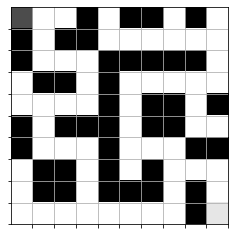

False

In [ ]:
play_game(model, Qmaze(maze), (0, 0), show_maze=True)

In [ ]:
maze = generate.load_maze("maze")
maze
maze


array([[1., 1., 1., 0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 1., 1., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1.]])

In [ ]:
def play_game(model, qmaze, pos, show_maze=False):
    '''
    Play the game given a neural network, a maze, and the starting position.
    '''
    # Reset to the initial position if not there already
    qmaze.reset(pos)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # Get the next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])
        # Apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            if show_maze:
                show(qmaze)
            return True
        elif game_status == 'lose':
            if show_maze:
                show(qmaze)
            return False

In [ ]:
qmaze.reset((0, 0))

In [ ]:
envstate = qmaze.observe()
envstate

array([[0.5, 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 0. , 1. ,
        0. , 0. , 0. , 0. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 0. ,
        0. , 1. , 1. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 0. , 1. , 1. ,
        1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. ]])

In [ ]:
model.predict(envstate)

ValueError: ignored

## # 미로 찾기 4 (사용 불가)
---

In [ ]:
!pip install gym
!pip install gym_minigrid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.7 MB/s 


In [ ]:
import gym
import gym_minigrid
from itertools import count
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

env = gym.make('MiniGrid-Dynamic-Obstacles-8x8-v0')#'MiniGrid-Empty-5x5-v0')
Fil_name='test_1'
PATH = './logs/'+Fil_name
print(env.observation_space)
print(env.action_space)


class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
def get_state(x):
	#print(x)
	x.unsqueeze_(0)
	
	x.transpose_(1,3)
	#print(x)
	return x


model = torch.load(PATH)
model.eval()
device = 'cpu'
def test_model(num_of_episodes,):
	
	
	for i in range(num_of_episodes):
		env.reset()

		state_dic,_,_,_=     env.step(env.action_space.sample())#env.render()
		state = get_state(torch.tensor(state_dic['image'],dtype =torch.float))
		reward_this_epi = 0
		for t in count():
			env.render()
			time.sleep(0.1)
			action = model(state).max(1)[1].view(1, 1)
			observation,reward ,done,_ =env.step(action.item())
			reward = torch.tensor([reward],dtype=torch.long, device=device)
			reward_this_epi = reward_this_epi+ reward.item()
			state =get_state(torch.tensor(observation['image'],dtype =torch.float))
			if done:
				reward_this_epi =reward_this_epi/(t+1)
				print('Episode:',i,'Episode_Score:',reward_this_epi,'Steps_alive',t+1)
				break

		
if __name__ == '__main__':
	print('Testing..')
	test_model(10)

Dict(image:Box(0, 255, (7, 7, 3), uint8))
Discrete(3)


FileNotFoundError: ignored

In [ ]:
import gym
import gym_minigrid
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('MiniGrid-Dynamic-Obstacles-8x8-v0')#'MiniGrid-Empty-5x5-v0')

print(env.observation_space)
print(env.action_space)



Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


BATCH_SIZE = 256 #128
GAMMA = 0.999
EPS_START = 1
EPS_END = 0.05

EPS_DECAY = 4000 #200 for 50 epi
num_episodes = 500
TARGET_UPDATE = 30
#PATH ='./logs/'

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()


init_screen = env.reset()
screen_height =7 
screen_width = 7 
device = 'cpu'
render_status = False
save_model = True
PATH = './logs/'

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(10000)


episode_durations = []
eps_of_episode = []
reward_hist=[]
steps_done = 0


def save_logs(Network , grap_plot ,Test_name , ith_sample):
    torch.save(Network,PATH+Test_name+ith_sample)
    plt.savefig(PATH+ith_sample+'.png')
    

def get_state(x):
	#print(x)
	x.unsqueeze_(0)
	
	x.transpose_(1,3)
	#print(x)
	return x

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
   	

    steps_done += 1
    eps_of_episode.append(eps_threshold)
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)




def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.subplot(221)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration_alive')
    plt.plot(durations_t.numpy())
    plt.subplot(222)
    #plt.title('Training...')
    plt.xlabel('Time_Steps')
    plt.ylabel('Epsilon')
    plt.plot(torch.tensor(eps_of_episode,dtype=torch.float).numpy())
    plt.subplot(223)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total_reward')
    rew_hist_tensor = torch.tensor(reward_hist,dtype=torch.float)
    plt.plot(rew_hist_tensor.numpy())
    #plt.show()

    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:

    	plt.subplot(221)
    	means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    	means = torch.cat((torch.zeros(99), means))
    	plt.plot(means.numpy())
    	plt.subplot(223)
    	means = rew_hist_tensor.unfold(0, 100, 1).mean(1).view(-1)
    	means = torch.cat((torch.zeros(99), means))
    	plt.plot(means.numpy())


    plt.pause(0.001)  # pause a bit so that plots are updated
    # if is_ipython:
    #     display.clear_output(wait=True)
    #     display.display(plt.gcf())      

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def train():
	
	for i_episode in range(num_episodes):
	    # Initialize the environment and state
	    env.reset()
	    #last_screen = env.render()

	    #current_screen = env.render()
	    
	    state_dic,_,_,_=     env.step(env.action_space.sample())#env.render()
	    state = get_state(torch.tensor(state_dic['image'],dtype =torch.float))
	    #print(state.size())
	    #print(state)
	    reward_epi = 0 
	    for t in count():
	        # Select and perform an action
	        if render_status:
	        	env.render()
	        action = select_action(state)
	        observation, reward, done, _ = env.step(action.item())
	        
	        reward = torch.tensor([reward],dtype=torch.long, device=device)
	        

	        # Observe new state
	        
	        
	        if not done:
	            next_state =get_state(torch.tensor(observation['image'],dtype =torch.float)) #env.render()# current_screen - last_screen
	        else:
	            next_state = None

	        # Store the transition in memory
	        memory.push(state, action, next_state, reward)

	        # Move to the next state
	        state = next_state

	        # Perform one step of the optimization (on the target network)
	        reward_epi = reward_epi+reward.item()
	        optimize_model()

	        if done:
	        	if t != 0:
	        		reward_epi = reward_epi/t
	        	reward_hist.append(reward_epi)
	        	episode_durations.append(t + 1)
	        	plot_durations()
	        	break
	        	
	    # Update the target network, copying all weights and biases in DQN
	    if i_episode % TARGET_UPDATE == 0:
	        target_net.load_state_dict(policy_net.state_dict())

	print('Complete')
	#env.render()
	env.close()
	#plt.ioff()
	#plt.show()


if __name__ == '__main__':
	print("Training :")
	train()
	Folder_name = 'test_(8x8)'
	if save_model == True :
		save_logs(policy_net,plt,Folder_name,'2')

	
	








# for i_episode in range(20):
#     observation = env.reset()
#     for t in range(100):
#         env.render()
#         print(observation)
#         action = env.action_space.sample()
#         observation, reward, done, info = env.step(action)
#         if done:
#             print("Episode finished after {} timesteps".format(t+1))
#             break
# env.close()

Output hidden; open in https://colab.research.google.com to view.

## # 미로찾기 5 (사용 안함)
---

In [ ]:
from re import escape
from threading import active_count
import os
import gym
import tensorflow as tf
import numpy as np
import random
from collections import deque

# 뉴럴 네트워크 모델 만들기
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_dim=64, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation='linear')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='mse')

score = []
memory = deque(maxlen=50000)


# FrozenLake8x8 환경 구성
env = gym.make('FrozenLake8x8-v0',is_slippery=False)
eps = 1

answer_queue = []

move_list = ['Left', 'Down','Right','Up']

# 10000회 에피소드 시작
for i in range(10000):
    print("========== Episode {} ==========".format(i+1))
    state_num = env.reset()
    state_arr = np.zeros(64)
    state_arr[state_num] = 1
    state = np.reshape(state_arr, [1, 64])
    answer_queue.clear()

    if eps > 0.01:
      eps *= 0.9995

    # 100 timesteps

    for t in range(100):

        if np.random.rand() < eps:
            action = np.random.randint(0, 3)
        else:
            predict = model.predict(state)
            action = np.argmax(predict)

        next_state_num, reward, done, _ = env.step(action)
        
        next_state_arr = np.zeros(64)
        next_state_arr[next_state_num] = 1
        next_state = np.reshape(next_state_arr, [1, 64])

        answer_queue.append(move_list[action])
        memory.append((state, action, reward, next_state, done))

        if done or t == 99:
            if next_state_num == 63:
              print("******** SUCCESS ********")

            for k in answer_queue:
              print(k + ' -> ', end='')
            print('')

            x = model.predict(state)[0]
            print('Left : ', x[0], ' Down : ', x[1] , ' Right : ', x[2] , ' Up : ', x[3])
            env.render()
            print('')
            break

        state = next_state.copy()
        state_num = next_state_num


    if i % 10 == 0:
      
      print("========== Episode {} 중간평가 ==========".format(i+1))
      state_num = env.reset()
      state_arr = np.zeros(64)
      state_arr[state_num] = 1
      state = np.reshape(state_arr, [1, 64])
      answer_queue.clear()

      for t in range(50):
         predict = model.predict(state)
         action = np.argmax(predict)
         next_state_num, reward, done, _ = env.step(action)
        
         next_state_arr = np.zeros(64)
         next_state_arr[next_state_num] = 1
         next_state = np.reshape(next_state_arr, [1, 64])

         answer_queue.append(move_list[action])
         

         if done or t == 49:
            if next_state_num == 63:
              print("******** SUCCESS ********")

            for k in answer_queue:
                print(k + ' -> ', end='')
            print('')

            x = model.predict(state)[0]
            print('Left : ', x[0], ' Down : ', x[1] , ' Right : ', x[2] , ' Up : ', x[3])
            env.render()
            print('')
            break

         state = next_state.copy()
         state_num = next_state_num

    # Training
    if i > 500:
        minibatch = random.sample(memory, 64)

        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + 0.9 * np.amax(model.predict(next_state)[0])
            target_outputs = model.predict(state)
            target_outputs[0][action] = target
            model.fit(state, target_outputs, epochs=1, verbose=0)

env.close()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

========== Episode 455 ==========
Right -> Left -> Left -> Right -> Right -> Right -> Right -> Right -> Right -> Left -> Left -> Left -> Right -> Right -> Left -> Right -> Left -> Right -> Right -> Right -> Right -> Right -> Up -> Down -> Left -> Right -> Down -> Right -> Left -> Left -> Left -> Down -> Right -> 
Left :  0.06488371  Down :  -0.060727447  Right :  0.031920988  Up :  0.016600499
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

========== Episode 456 ==========
Right -> Down -> Down -> Down -> Left -> Down -> Left -> Right -> Down -> 
Left :  0.047427796  Down :  -0.09417593  Right :  0.04830369  Up :  0.039620116
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

========== Episode 457 ==========
Down -> Down -> Right -> Down -> Left -> Down -> Left -> Left -> Down -> Down -> Up -> Right -> 
Left :  

## # 미로찾기 6 (사용 불가)
---

1
total call vs corrected answer : 0 0


KeyboardInterrupt: ignored

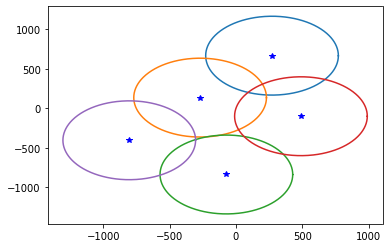

In [ ]:
# library

import sys

import math as mt
import numpy as np

import itertools
import matplotlib.pyplot as plt


# function definition

def circle(x, y,r):
    ang=np.arange(0, 2*mt.pi, 0.01)
    xp=r*np.cos(ang)
    yp=r*np.sin(ang)
    plt.plot(x+xp,y+yp)
    return

def random_beam():
    x=[]
    x.append(60)
    x.append((60+120)%360)
    x.append((60-120)%360)
    return x

def point_d(thita,x1,y1,l):
    x2=[]
    y2=[]
    if thita==90:
        x2.append(x1)
        x2.append(x1)
        y2.append(y1+l)
        y2.append(y1-l)
    if (thita>180 and thita<270) or (thita<=180 and thita>90):
        x2.append(l*np.cos(np.deg2rad(thita)) + x1)
        y2.append(l * np.sin(np.deg2rad(thita)) + y1)
        x2.append(-l * np.cos(np.deg2rad(thita)) + x1)
        y2.append(-l * np.sin(np.deg2rad(thita)) + y1)
    else:
        x2.append(-l*np.cos(np.deg2rad(thita)) + x1)
        y2.append(-l * np.sin(np.deg2rad(thita)) + y1)
        x2.append(l * np.cos(np.deg2rad(thita)) + x1)
        y2.append(l * np.sin(np.deg2rad(thita)) + y1)


    return x2, y2



def random_allocation(c_x,c_y,angl,d,rng,num):
    X=[]
    Y=[]
    x=np.random.randint(d,rng+1,num)
    y=np.random.randint(0,angl,num)
    for i in range(num) :
        [a,b]=point_d(y[i],c_x,c_y,x[i])
        if y[i]<90 or y[i]>270 :
            X.append(a[1])
            Y.append(b[1])
        else:
            X.append(a[0])
            Y.append(b[0])
    return X,Y



def find_points_in_angle(x2,y2,x3,y3,angl,q,w):
    result_x=[]
    result_y=[]
    ang=[]
    global U_neighbor
    global U_neighbor_sector
    for i in range(len(x3)):
        if (x3[i]-x2)==0:
            if y3[i]>=y2:
                ang.append(90)
            else:
                ang.append(270)
        else:
            ang.append(np.rad2deg(np.arctan2((y3[i]-y2),(x3[i]-x2)))%360)
        angl1=angl+60
        angl2=angl-60
        if angl1>=360 and ang[i]>=0 and ang[i]<90:
            ang[i]=ang[i]+360
        if angl2<0:
            angl2=angl2%360
        if angl2>angl1:
            angl1=angl1+360
            if ang[i]>=0 and ang[i]<180:
                ang[i]=ang[i]+360
        r=ang[i]
        if angl2<=r and r<=angl1:
            t=1
        else:
            t=0
        if t==1:
            result_x.append(x3[i])
            result_y.append(y3[i])
            U_neighbor[i].extend([q])
            U_neighbor_sector[i].extend([w])
            t=0

    return result_x, result_y

def find_dis(x1,y1,x0,y0):
    return np.sqrt((x0-x1)**2+(y0-y1)**2)

def find_angl(x2,y2,x3,y3,angl):
    z=[]
    if (x3-x2)==0:
        if y3>=y2:
            ang=90
            z=ang
        else:
            ang=270
            z=ang
    else:
        ang=np.rad2deg(np.arctan2((y3-y2),(x3-x2)))%360
        if angl>=0 and angl<90 and ang>270 and ang < 360 :
            z=360-(ang-angl)
        elif ang >= 0 and ang < 90 and angl > 270 and angl < 360:
            z=360-(angl-ang)
        else:
            z=np.abs(angl-ang)

    return z

def power_watt_dbm(power):
    return 10*np.log10(power*1000)

def transmit_power(thita,thita_3db,Am, power_dbm):
    x=-np.min([12*(thita/thita_3db)**2, Am])
    g_x=10**(x/10)
    return (10**(power_dbm/10))/1000*g_x

def pw_m_hata(p,d):
    pl=128.1+37.6*np.log10(d/1000)
    G=10**(-pl/10)
    return G*p



def profile_power(subbands,slot,p_setting,power):
    ln=len(p_setting)

    pset=[]
    for i in range(len(slot)):

        p=power+1
        t=0
        k=[]
        while (p>=power):
            p=0
            t=t+1
            l=[]
            for j in range(len(subbands)):

                l.append(np.random.randint(0,ln,1))
                p=p+(subbands[j]*p_setting[l[j][0]])
            k.append(l)

        for j in range(len(subbands)):
            pset.append(p_setting[k[t - 1][j][0]])

    return pset


def convert_subband_power(sub,x):
    z=[]
    for i in range(len(x)) :
        z.append(sub[i]*x[i])

    return z


def generate_power_matrix_macro():
    global thita
    global U_x
    global num_M
    global N_subband
    global P_macro_subband
    global thita_3db
    global A_m
    global U_received_power_subband
    U_received_power_subband=[]

    for i in range(len(U_x)):
        U_received_power_subband.append([])

        for j in range(num_M):
            U_received_power_subband[i].append([])

            for a in range(N_subband):
                pw=P_macro_subband[j][a]
                pw_R= transmit_power(thita[i][j], thita_3db, A_m, power_watt_dbm(pw))
                U_received_power_subband[i][j].append(pw_m_hata(pw_R,U_macro_distance[i][j]))

    return

def sinr_db(p,pn):

    return 10* np.log10(p/pn)

def db_sinr(val):

    return 10**(val/10)

def sinr_to_cqi(i):

    if i<=-5:
        out=1

    elif i <=-2.5 and i> -5:
        out=2

    elif i <=0 and i> -2.5:
        out=3

    elif i <=2.4 and i> 0:
        out=4

    elif i <=4 and i>2.4:
        out=5

    elif i <=6 and i> 4:
        out=6

    elif i <=8 and i> 6:
        out=7

    elif i <=10 and i> 8:
        out=8

    elif i <=13 and i> 10:
        out=9

    elif i <=16 and i> 13:
        out=10

    elif i <=18 and i> 16:
        out=11

    elif i <=20.5 and i> 18:
        out=12

    elif i <=24 and i> 20.5:
        out=13

    elif i <=26.4 and i> 24:
        out=14

    elif i> 26.4:
        out=15

    return  out

def shanon_formula(p,pn):
    alpha=1
    del_f=12*15*10**3
    N0=(10**(-174/10))/1000
    z1=p/(N0*del_f+pn)

    return del_f*np.log2(1+alpha*z1)


def throughput():
    global U_received_power_subband
    global U_throughput_subband
    global U_SINR_subband
    global U_CQI_subband
    global P_own
    global P_intr
    global sub
    global U_x
    global U_association_macro
    global N_subband
    global num_M

    U_throughput_subband=[]
    U_SINR_subband=[]
    U_CQI_subband=[]

    for i in range(len(U_x)):
        U_throughput_subband.append([])
        U_SINR_subband.append([])
        U_CQI_subband.append([])
        q=U_association_macro[i]

        if q>0:
            id_cell=q-1
            P_own=[]
            P_intr=[]

            for X in range(N_subband):
                P_own.append(U_received_power_subband[i][id_cell][X])
                P_intr.append(0)

                for H in range(num_M):

                    if H !=id_cell:
                        P_intr[X] = P_intr[X] + U_received_power_subband[i][H][X]

                U_SINR_subband[i].append(sinr_db(P_own[X], P_intr[X]))
                U_CQI_subband[i].append(sinr_to_cqi(U_SINR_subband[i][X]))
                U_throughput_subband[i].append(sub[X] * shanon_formula(P_own[X], P_intr[X]) / (1024 * 1024))

    return



def calculate_sinr(cell_m,user_i,subband_x):

    return db_sinr(U_SINR_subband[(num_U*cell_m)+user_i][subband_x])


def calculate_gain(cell_m,user_i):

    d=U_macro_distance[(num_U*cell_m)+user_i][cell_m]

    pl=128.1+37.6*np.log10(d/1000)
    G=10**(-pl/10)
    #print('G    :',G)
    return G

def calculate_power(cell_m,cell_n,user_i,subband_x):

    pw = P_macro_subband[cell_m][subband_x]
    pw_R = transmit_power(thita[(num_U*cell_n)+user_i][subband_x], thita_3db, A_m, power_watt_dbm(pw))
    #print(pw,pw_R)
    return pw_R



def optimize_resource_ga():
    global ga_comb
    global ga_comb2
    global ga_fit_comb
    global P_macro_subband
    global N_subband
    global O_macro_pos
    global O_macro_no
    global O_macro_sum
    global num_M
    global num_U
    global sub
    global slots_slots
    global MC_power
    global P_max_macro

    O_macro_sum=[]
    ga_comb_temp=[]

    for itr1 in range(6000):
        x=[]

        for i in range(num_M):
           x.extend(profile_power(sub,slots_slots,MC_power,P_max_macro))

        ga_comb_temp.append(x)

    ga_comb=np.unique(ga_comb_temp,axis=0).tolist()


    for itr1 in range(len(ga_comb)):

        for i in range(len(M_x)):
            P_macro_subband[i]=ga_comb[itr1][i*N_subband: (i+1)*N_subband]

        #print(ga_comb_temp[itr1],P_macro_subband)
        generate_power_matrix_macro()
        throughput()

        O_macro_no = []
        O_macro_pos = []

        for i in range(len(M_x)):
            [a,b]=calc_max(i*num_U,((i+1)*num_U))
            O_macro_no.append(a)
            O_macro_pos.append(b)

        O_macro_sum.append(np.sum(O_macro_no))

    q=np.sort(O_macro_sum).tolist()
    Q = np.sort(O_macro_sum).tolist()
    w = np.argsort(O_macro_sum).tolist()
    W = np.argsort(O_macro_sum).tolist()

    O_macro_no=[]
    O_macro_pos=[]
    O_macro_sum=[]
    ga_fit_comb=[[],[],[],[],[],[],[],[],[],[],[],[]]
    ga_comb2=ga_comb

    LEN=len(ga_comb2)
    sys.stdout.flush()
    for uu in range(3000):
        O_macro_no = []
        O_macro_pos = []
        O_macro_sum=[]
        #prev_config=[]

        ga_fit_comb[0]=ga_comb[w[-1]]
        ga_fit_comb[1] = ga_comb[w[-2]]
        ga_fit_comb[2] = ga_comb[w[-3]]
        ga_fit_comb[3] = ga_comb[w[-4]]

        ga_comb=[]
        w=[]
        q=[]

        [ga_fit_comb[4],ga_fit_comb[5]]=split_merge_ga(ga_fit_comb[0],ga_fit_comb[1])
        ga_fit_comb[4]=mutation_ga(ga_fit_comb[4])
        ga_fit_comb[5] = mutation_ga(ga_fit_comb[5])

        [ga_fit_comb[6], ga_fit_comb[7]] = split_merge_ga(ga_fit_comb[0], ga_fit_comb[2])
        ga_fit_comb[6] = mutation_ga(ga_fit_comb[6])
        ga_fit_comb[7] = mutation_ga(ga_fit_comb[7])

        [ga_fit_comb[8], ga_fit_comb[9]] = split_merge_ga(ga_fit_comb[0], ga_fit_comb[3])
        ga_fit_comb[8] = mutation_ga(ga_fit_comb[8])
        ga_fit_comb[9] = mutation_ga(ga_fit_comb[9])


        [ga_fit_comb[2], ga_fit_comb[3]] = split_merge_ga(ga_comb2[W[np.random.randint(LEN-10, LEN,1)[0]]], ga_comb2[W[np.random.randint(LEN-10, LEN,1)[0]]])
        ga_fit_comb[2] = mutation_ga(ga_fit_comb[2])
        ga_fit_comb[3] = mutation_ga(ga_fit_comb[3])

        [ga_fit_comb[10], ga_fit_comb[11]] = split_merge_ga(ga_comb2[W[np.random.randint(LEN - 50, LEN, 1)[0]]],ga_comb2[W[np.random.randint(LEN - 50, LEN, 1)[0]]])
        ga_fit_comb[10] = mutation_ga(ga_fit_comb[10])
        ga_fit_comb[11] = mutation_ga(ga_fit_comb[11])

        ga_comb = np.unique(ga_fit_comb, axis=0).tolist()

        OM_position=[]

        for itr1 in range(len(ga_comb)):

            for i in range(len(M_x)):
                P_macro_subband[i] = ga_comb[itr1][i * N_subband: (i + 1) * N_subband]

            # print(ga_comb_temp[itr1],P_macro_subband)
            generate_power_matrix_macro()
            throughput()

            O_macro_no = []
            O_macro_pos = []

            for i in range(len(M_x)):
                [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
                O_macro_no.extend(a)
                O_macro_pos.extend(b)

            #print(O_macro_pos)
            OM_position.append(O_macro_pos)
            O_macro_sum.append(np.sum(O_macro_no))

        #print(O_macro_sum)

        q = np.sort(O_macro_sum).tolist()
        w = np.argsort(O_macro_sum).tolist()

        current_config = ga_comb[w[-1]]

        if uu==0:
            prev_config= ga_comb[w[-1]]
            cont_itr=0

        if current_config==prev_config :
            cont_itr=cont_itr+1
        else:
            cont_itr=0

        prev_config=ga_comb[w[-1]]


        if cont_itr >500:
            break

    power_config=ga_comb[w[-1]]
    ff=np.digitize(power_config,MC_power).tolist()
    ff.extend(OM_position[w[-1]])
    #print("power_config",ff)
    #g_ga_th.append(q[-1])
    #print("throughput_ga :", q[-1])
    return power_config,ff,q[-1]

def calc_max(xi,xe):
    global U_throughput_subband

    return np.amax(U_throughput_subband[xi:xe],axis=0).tolist() , np.argmax(U_throughput_subband[xi:xe],axis=0).tolist()


def split_merge_ga(v1,v2):

    z1=[]
    z2=[]
    a=np.random.randint(1,num_M+1,1)
    b = np.random.randint(0, num_M+1 - a, 1)

    temp_v11=v1[0:(a[0]-1)*N_subband]
    temp_v12 = v1[(a[0]-1) * N_subband: (a[0]+b[0])*N_subband]
    temp_v13 = v1[(a[0] + b[0]) * N_subband:]

    temp_v21 = v2[0:(a[0] - 1) * N_subband]
    temp_v22 = v2[(a[0] - 1) * N_subband: (a[0] + b[0]) * N_subband]
    temp_v23 = v2[(a[0] + b[0]) * N_subband:]

    z1.extend(temp_v11)
    z1.extend(temp_v22)
    z1.extend(temp_v13)

    z2.extend(temp_v21)
    z2.extend(temp_v12)
    z2.extend(temp_v23)

    return z1, z2

def mutation_ga(v):

    global MC_power
    z=[]

    temp=v[:]

    a=np.random.randint(0,7,1)
    if a[0]==1:
        ln=len(v)
        p1=np.random.randint(0,ln,1)
        q1=np.random.randint(0,len(MC_power),1)

        p2 = np.random.randint(0, ln, 1)
        q2 = np.random.randint(0, len(MC_power), 1)

        temp[p1[0]]=MC_power[q1[0]]
        temp[p2[0]] = MC_power[q2[0]]

        right=check_max(temp)

        if right <0.5:
            z=temp
        else:
            z=v

    elif a[0] == 2:
        ln = len(v)
        p1 = np.random.randint(0, ln, 1)
        q1 = np.random.randint(0, len(MC_power), 1)

        p2 = np.random.randint(0, ln, 1)
        q2 = np.random.randint(0, len(MC_power), 1)

        p3 = np.random.randint(0, ln, 1)
        q3 = np.random.randint(0, len(MC_power), 1)

        temp[p1[0]] = MC_power[q1[0]]
        temp[p2[0]] = MC_power[q2[0]]
        temp[p3[0]] = MC_power[q3[0]]

        right = check_max(temp)

        if right < 0.5:
            z = temp
        else:
            z = v

    elif a[0] == 3:
        ln = len(v)
        p1 = np.random.randint(0, ln, 1)
        q1 = np.random.randint(0, len(MC_power), 1)

        p2 = np.random.randint(0, ln, 1)
        q2 = np.random.randint(0, len(MC_power), 1)

        p3 = np.random.randint(0, ln, 1)
        q3 = np.random.randint(0, len(MC_power), 1)

        p4 = np.random.randint(0, ln, 1)
        q4 = np.random.randint(0, len(MC_power), 1)

        temp[p1[0]] = MC_power[q1[0]]
        temp[p2[0]] = MC_power[q2[0]]
        temp[p3[0]] = MC_power[q3[0]]
        temp[p4[0]] = MC_power[q4[0]]

        right = check_max(temp)

        if right < 0.5:
            z = temp
        else:
            z = v

    elif a[0] == 4:
        ln = len(v)
        p1 = np.random.randint(0, ln, 1)
        q1 = np.random.randint(0, len(MC_power), 1)

        p2 = np.random.randint(0, ln, 1)
        q2 = np.random.randint(0, len(MC_power), 1)

        p3 = np.random.randint(0, ln, 1)
        q3 = np.random.randint(0, len(MC_power), 1)

        p4 = np.random.randint(0, ln, 1)
        q4 = np.random.randint(0, len(MC_power), 1)

        p5 = np.random.randint(0, ln, 1)
        q5 = np.random.randint(0, len(MC_power), 1)

        temp[p1[0]] = MC_power[q1[0]]
        temp[p2[0]] = MC_power[q2[0]]
        temp[p3[0]] = MC_power[q3[0]]
        temp[p4[0]] = MC_power[q4[0]]
        temp[p5[0]] = MC_power[q5[0]]

        right = check_max(temp)

        if right < 0.5:
            z = temp
        else:
            z = v


    else :
        ln = len(v)
        p = np.random.randint(0, ln, 1)
        q = np.random.randint(0, len(MC_power), 1)

        temp[p[0]] = MC_power[q[0]]

        right = check_max(temp)

        if right < 0.5:
            z = temp
        else:
            z = v


    return z


def check_max(v):

    z=0
    for irr in range(num_M):

        if np.sum(v[irr*N_subband:(irr+1)*N_subband]) <= 2.5 :
            z=(z | 0)
        else:
            z= (z | 1)

    return z

def check_ga_with_drl(action):
    global g_total_call
    global g_total_corrected
    global final_comb
    global M_x
    global ln_fl_comb
    action_drl=[]
    if (g_cntr-1) < g_data_len:
        #print("running ---------------")
        action_ga=data_set['arr_2'][g_cntr-1].tolist()
        ga_th=data_set['arr_3'][g_cntr-1].tolist()
       # action_wmmse = data_set['arr_4'][g_cntr - 1].tolist()
       # wmmse_th = data_set['arr_5'][g_cntr - 1].tolist()

    else:

        action_ga,_,ga_th=optimize_resource_ga()
        g_data_action_ga.append(action_ga)
        g_data_ga_th.append(ga_th)
       # action_wmmse, wmmse_th = optimize_resource_wmmse()
       # g_data_action_wmmse.append(action_wmmse)
       # g_data_wmmse_th.append(wmmse_th)


    g_ga_th.append(ga_th)
  #  g_wmmse_th.append(wmmse_th)

    #print("throughput_ga :", ga_th)

    #for i in range(len(M_x)):
      #  action_drl.extend(final_comb[action[i]-i*ln_fl_comb])
    #answer=np.double(action_drl==action_ga)
    #print(answer,action_drl,action_ga)
    #g_total_call=g_total_call+1
    #g_total_corrected=g_total_corrected+answer
    #g_drl_th.append(g_drl_th_val)

    #g_eql_th.append(g_eql_th_val)
    #g_rnd_th.append(g_rnd_th_val)



  #  print("Throughput GA: ",ga_th,' DRL: ', g_drl_th_val,' EQL: ', g_eql_th_val,' RND: ',g_rnd_th_val,' WMMSE: ',wmmse_th)
    np.savez("result_5c_2h_5p_lr2.npz", g_ga_th)
    np.save("counter_v2_5c_2h_5p_lr2.npy",g_cntr)
    if g_cntr > g_data_len:
        np.savez("data_set_5c.npz",g_data_x,g_data_y,g_data_action_ga,g_data_ga_th)


    return


########################################################################################################################



def optimize_resource_wmmse():

    #v_k_0=np.random.rand(0,np.sqrt(0.8),num_M)
    global P_macro_subband
    global N_subband
    global num_U
    global num_M
    global ln_fl_comb
    global final_comb
    global k_m_n
    global v_k_old
    global u_k_old
    global w_k_old


    global v_k_new
    global u_k_new
    global w_k_new

    del_f = 12 * 15 * 10 ** 3
    N0 = (10 ** (-174 / 10)) / 1000


    for i in range(num_M):
        P_macro_subband[i] = final_comb[np.random.randint(0, ln_fl_comb)]

    v_k_old=np.sqrt(P_macro_subband).tolist()

    generate_power_matrix_macro()
    throughput()

    K_macro_no = []
    k_m_n = []

    # for calculating user association

    for i in range(len(M_x)):
        [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
        # K_macro_no.append(a)
        k_m_n.append(b)
    #print(k_m_n)

    # for u_k_old
    u_k_old=[]

    for i in range(len(M_x)):      # u_k
        u_k_old.append([])

        for X in range(N_subband):   # u_k^n

            sum_den = 0
            for j in range(len(M_x)):    # j=1

                sum_den = sum_den + (calculate_gain(j, k_m_n[i][X]) * calculate_power(j, i, k_m_n[i][X], X) )

            sum_den=sum_den+(N0*del_f)

            u_k_old[i].append(np.sqrt(calculate_gain(i,k_m_n[i][X])) * np.sqrt(calculate_power(i, i, k_m_n[i][X], X))/ sum_den)

    # for u_k_old
    w_k_old=[]

    for i in range(len(M_x)):      # w_k
        w_k_old.append([])

        for X in range(N_subband):   # w_k^n

            w_k_old[i].append(1/ (u_k_old[i][X] * np.sqrt(calculate_gain(i,k_m_n[i][X])) *  np.sqrt(calculate_power(i, i, k_m_n[i][X], X))))
    for itr_wmmse in range(40):

        update_v_k()
        update_u_k()
        update_w_k()
        if u_k_old==u_k_new:
            break
        u_k_old=u_k_new
        w_k_old=w_k_new

    generate_power_matrix_macro()
    throughput()

    O_macro_no = []
    O_macro_pos = []

    for i in range(len(M_x)):
        [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
        O_macro_no.append(a)
        O_macro_pos.append(b)



    #print('Final   :',P_macro_subband)



    return P_macro_subband, np.sum(O_macro_no)   # action , throughput

def update_v_k():
    global P_macro_subband
    global v_k_new
    global u_k_old
    global w_k_old
    global k_m_n
    # for v_k_new
    v_k_new = []

    for i in range(len(M_x)):  # v_k
        v_k_new.append([])

        for X in range(N_subband):  # v_k^n

            sum_den = 0
            for j in range(len(M_x)):  # j=1

                sum_den = sum_den + (calculate_gain(j, k_m_n[i][X]) * (( u_k_old[j][X])**2) * w_k_old[j][X])

            #sum_den = sum_den + 1

            v_k_new[i].append(
                np.sqrt(calculate_gain(i, k_m_n[i][X])) * w_k_old[i][X] * u_k_old[i][X] / sum_den)

    P_macro_subband=np.square(v_k_new).tolist()

    normalized_check_max()

    generate_power_matrix_macro()
    throughput()

    k_m_n = []

    # for calculating user association

    for i in range(len(M_x)):
        [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
        # K_macro_no.append(a)
        k_m_n.append(b)

    #print(np.square(v_k_new).tolist())
    #print(P_macro_subband)

    return

def update_u_k():
    global u_k_new

    del_f = 12 * 15 * 10 ** 3
    N0 = (10 ** (-174 / 10)) / 1000
    u_k_new = []

    for i in range(len(M_x)):  # u_k
        u_k_new.append([])

        for X in range(N_subband):  # u_k^n

            sum_den = 0
            for j in range(len(M_x)):  # j=1

                sum_den = sum_den + (calculate_gain(j, k_m_n[i][X]) * calculate_power(j, i, k_m_n[i][X], X))

            sum_den = sum_den + (N0 * del_f)

            u_k_new[i].append(
                np.sqrt(calculate_gain(i, k_m_n[i][X])) * np.sqrt(calculate_power(i, i, k_m_n[i][X], X)) / sum_den)

    #print(u_k_new)

    return

def update_w_k():
    global w_k_new
    w_k_new = []

    for i in range(len(M_x)):  # w_k
        w_k_new.append([])

        for X in range(N_subband):  # w_k^n

            w_k_new[i].append(1 / (u_k_new[i][X] * np.sqrt(calculate_gain(i, k_m_n[i][X])) * np.sqrt(
                calculate_power(i, i, k_m_n[i][X], X))))

    return

def normalized_check_max():


    for i in range(len(M_x)):  #

        for X in range(N_subband):  #
            P_macro_subband[i][X]= normalized_power(P_macro_subband[i][X])

        if np.sum(P_macro_subband[i][0:N_subband]) >2.41:
            P_macro_subband[i]=(0.8*np.ones(N_subband)).tolist()




    return


def normalized_power(inpt):

    if inpt <(MC_power[0]+MC_power[1])/2:
        output=MC_power[0]
    elif (MC_power[0]+MC_power[1])/2 <= inpt < (MC_power[1]+MC_power[2])/2:
        output=MC_power[1]
    elif (MC_power[1]+MC_power[2])/2 <= inpt < (MC_power[2]+MC_power[3])/2:
        output=MC_power[2]
    elif (MC_power[2]+MC_power[3])/2 <= inpt < (MC_power[3]+MC_power[4])/2:
        output=MC_power[3]
    elif (MC_power[3]+MC_power[4])/2 <= inpt :
        output=MC_power[4]

    return output




# -------------------- ENVIRONMENT ---------------------

#s,s_ini = self.env_reset()

def env_reset():
    global thita
    global g_drl_th_val
    global g_eql_th_val
    global g_rnd_th_val
    global thita_3db
    global P_max_macro
    global MC_power
    global slots_slots
    global sub
    global A_m
    global R_m
    global num_U
    global num_M
    global M_x
    global M_y
    global M_cell_beam
    global M_cell_associated_user_id
    global U_x
    global U_y
    global U_association_macro
    global U_neighbor
    global U_neighbor_sector
    global M_cell_region_x
    global M_cell_region_y
    global U_macro_distance
    global U_macro_power
    global M_cell_txblock_power
    global P_macro_subband
    global U_received_power_subband
    global U_throughput_subband
    global U_SINR_subband
    global U_CQI_subband
    global g_action
    global g_cntr

    global current_throughput
    global previous_throughput

    global g_counter

    global k_m_n
    global v_k_old
    global u_k_old
    global w_k_old

    global v_k_new
    global u_k_new
    global w_k_new

    k_m_n = []
    v_k_old = []
    u_k_old = []
    w_k_old = []

    v_k_new = []
    u_k_new = []
    w_k_new = []

    g_counter = 0
    current_throughput = []
    previous_throughput = 0
    g_drl_th_val = 0
    g_eql_th_val = 0
    g_rnd_th_val = 0

    M_cell_beam = []
    M_cell_associated_user_id = []
    M_cell_region_x = []
    M_cell_region_y = []
    M_cell_txblock_power = []

    U_x = []
    U_y = []
    U_association_macro = []
    U_neighbor = []
    U_neighbor_sector = []
    U_macro_distance = []
    U_macro_power = []
    U_throughputt = []

    P_macro_subband = []
    U_received_power_subband = []
    U_throughput_subband = []

    U_SINR_subband = []
    U_CQI_subband = []

    itr = 0
    for i in range(len(M_x)):
        M_cell_beam.append(random_beam())
        M_cell_associated_user_id.append([])

        for j in range(num_U):
            M_cell_associated_user_id[i].extend([itr + 1])
            U_association_macro.append(i + 1)
            itr = itr + 1

        # [x, y] = random_allocation(M_x[i], M_y[i], 360, 0.2 * R_m, R_m, num_U)
        # U_x.extend(x)
        # U_y.extend(y)

    # ***********************************************************************************************************************

    # g_data_x.append(U_x)
    # g_data_y.append(U_y)
    if g_cntr < g_data_len:
        U_x = data_set['arr_0'][g_cntr].tolist()
        # print(U_x)
        U_y = data_set['arr_1'][g_cntr].tolist()

    else:
        for i in range(len(M_x)):
            [x, y] = random_allocation(M_x[i], M_y[i], 360, 0.2 * R_m, R_m, num_U)
            U_x.extend(x)
            U_y.extend(y)

        g_data_x.append(U_x)
        g_data_y.append(U_y)

    g_cntr = g_cntr + 1
    print(g_cntr)

    # ***********************************************************************************************************************
    for i in range(len(U_x)):
        U_neighbor.append([])
        U_neighbor_sector.append([])

    for i in range(len(M_x)):
        M_cell_region_x.append([[], [], []])
        M_cell_region_y.append([[], [], []])

        for j in range(3):
            [a, b] = find_points_in_angle(M_x[i], M_y[i], U_x, U_y, M_cell_beam[i][j], i + 1, j + 1)
            M_cell_region_x[i][j].extend(a)
            M_cell_region_y[i][j].extend(b)

    thita = np.zeros((len(U_x), len(M_x)))

    for i in range(len(U_x)):
        U_macro_distance.append([])
        U_macro_power.append([])

        for j in range(len(M_x)):
            U_macro_distance[i].append(find_dis(U_x[i], U_y[i], M_x[j], M_y[j]))
            angl = M_cell_beam[j][U_neighbor_sector[i][j] - 1]

            thita[i][j] = find_angl(M_x[j], M_y[j], U_x[i], U_y[i], angl)
            a = transmit_power(thita[i][j], thita_3db, A_m, power_watt_dbm(P_max_macro))
            U_macro_power[i].append(pw_m_hata(a, U_macro_distance[i][j]))

    for i in range(len(M_x)):
        M_cell_txblock_power.append(profile_power(sub, slots_slots, MC_power, P_max_macro))
        P_macro_subband.append(M_cell_txblock_power[i])

    generate_power_matrix_macro()

    throughput()

    temp_var = []

    for i in range(num_M * num_U):
        temp_var.extend(U_CQI_subband[i])
        temp_var.append(np.double(U_macro_distance[i][U_association_macro[i] - 1] / R_m >= 0.5))

    return np.array(temp_var)


########################################################################################################################

# variable definition

current_throughput=[]
previous_throughput=0

g_counter=0
g_action=[]
g_total_call=0
g_total_corrected=0
g_ga_th=[]
g_wmmse_th=[]
g_drl_th_val=0
g_drl_th=[]
g_eql_th_val=0
g_rnd_th_val=0
g_eql_th=[]
g_rnd_th=[]

g_cntr=0
g_data_len=0

g_data_x=[]
g_data_y=[]

g_data_action_ga=[]
g_data_vector_ga=[]
g_data_ga_th=[]

g_data_action_wmmse=[]
g_data_wmmse_th=[]



M_cell_beam=[]
M_cell_associated_user_id=[]
M_cell_cor_x=[]
M_cell_cor_y=[]
M_cell_region_x=[]
M_cell_region_y=[]
M_cell_txblock_power=[]

U_x=[]
U_y=[]
U_association_macro=[]
U_neighbor=[]
U_neighbor_sector=[]
U_macro_distance=[]
U_macro_power=[]
U_throughputt=[]

P_macro_subband=[]

U_received_power_subband=[]
U_throughput_subband=[]
U_SINR_subband=[]
U_CQI_subband=[]

ga_comb=[]
ga_comb2=[]
ga_fit_comb=[]

O_macro_no=[]
O_macro_pos=[]
O_macro_sum=[]

thita=[]


thita_3db=70
A_m=35
P_max_macro=40
alpha=25
r=1000
R_m=500
min_RM=600
num_M=5
num_U=5
N=9000
N_subband=3

MC_power_1=[0.4, 0.6, 0.8,1.0,1.2]
MC_power=[0.4,0.6, 0.8,1.0,1.2]

N_RB=48
N_slot=1
N_subframes=1
sub=[]
slots_slots=[1]
sub.append(mt.floor(N_RB/N_subband))
sub.append(mt.floor(N_RB/N_subband))

# for 5 cell system
M_x=[272, -270, -72, 490, -804]
M_y=[668, 136, -839, -100, -405]

# for 10 cell system
#M_x=[-507.325029580438,1002.33404665068,145.312062677023,200.78357265330,1638.02723651541,1373.51667496699,-505.567176719993,89.0624746033709,888.768341569969,700.98746226480]
#M_y=[622.439530990585,1204.09269092070,-857.441644095846,0.776230721301,-266.682269021143,409.885301601770,-276.654621800917,971.99443198228,-404.073417200223,500.42153804114]

# for 15 cell system
#M_x=[-507.325029580438,1002.33404665068,145.312062677023,1008.94157032003,200.78357265330,1638.02723651541,1373.51667496699,-505.567176719993,89.0624746033709,208.3844792471699,-1205.45088276488,-1203.86653509258,888.768341569969,-623.017861398548,700.98746226480]
#M_y=[622.439530990585,1204.09269092070,-857.441644095846,-1254.30978634305,0.776230721301,-566.682269021143,309.885301601770,-276.654621800917,971.99443198228,-1708.16795562791,281.640997912069,-609.705714626437,-404.073417200223,-1209.60615767022,500.42153804114]


sub.append(N_RB-sub[N_subband-2]*(N_subband-1))
#print(sub)
final_comb=[]
P_own=[]
P_intr=[]
P_SINR=[]


# final_comb : combination of all the actions for a particular cell

power_comb = list(map(list, itertools.product(MC_power_1, repeat=N_subband)))

for i in power_comb:
    temp_sum=0.0
    for j in range(N_subband):
        temp_sum=temp_sum+ i[j]*sub[j]
    if temp_sum <=40 :
        final_comb.append(i)

ln_fl_comb=len(final_comb)

#print(final_comb[12])

plt.figure(1)
plt.plot(M_x,M_y,'b*')

for i in range(len(M_x)):
    circle(M_x[i],M_y[i],R_m)
#plt.show()  # to plot the figure








try:

    g_cntr=0

    ########################################################################################################################
    #g_cntr=np.load("counter_5c_1.npy").tolist()
    #data_set = np.load("data_set_5c_1.npz")
    #g_data_len = len(data_set['arr_0'])
    #g_data_x = data_set['arr_0'].tolist()
    #g_data_y = data_set['arr_1'].tolist()
    #g_data_action_ga = data_set['arr_2'].tolist()
    #g_data_ga_th = data_set['arr_3'].tolist()
    #g_data_action_wmmse = data_set['arr_4'].tolist()
    #g_data_wmmse_th = data_set['arr_5'].tolist()
    #g_data_vector_ga=data_set['arr_6'].tolist()
    #print(g_data_len,g_cntr)
    #print(g_data_ga_th)



    ########################################################################################################################

    while True:
        s=env_reset().tolist()
        #print(s)
        #a,b,c=optimize_resource_ga()
        #print(a,b,c)

        if (g_cntr) > g_data_len:
            action_ga, vector_ga, ga_th = optimize_resource_ga()
            #print(s)
            s.extend(vector_ga)
            vector_ga=s
            #print(vector_ga)
            g_data_action_ga.append(action_ga)
            g_data_ga_th.append(ga_th)
            g_data_vector_ga.append(vector_ga)
            action_wmmse, wmmse_th = optimize_resource_wmmse()
            g_data_action_wmmse.append(action_wmmse)
            g_data_wmmse_th.append(wmmse_th)

        np.save("counter_5c_1", g_cntr)
        if g_cntr > g_data_len:
            np.savez("data_set_5c_1.npz", g_data_x, g_data_y, g_data_action_ga, g_data_ga_th, g_data_action_wmmse, g_data_wmmse_th,g_data_vector_ga)


finally:
   # agent.brain.model.save("dqn_5c_2h_5p_lr2.h5")
    #np.save("data_5c_2h_5p_lr2.npy", agent.memory.samples)

    print("total call vs corrected answer :", g_total_call,g_total_corrected)









In [ ]:
# library

import sys
import math
import random
import math as mt
import numpy as np
import time
from keras import backend as K
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt


# function definition

def circle(x, y,r):
    ang=np.arange(0, 2*mt.pi, 0.01)
    xp=r*np.cos(ang)
    yp=r*np.sin(ang)
    plt.plot(x+xp,y+yp)
    return

def random_beam():
    x=[]
    x.append(60)
    x.append((60+120)%360)
    x.append((60-120)%360)
    return x

def point_d(thita,x1,y1,l):
    x2=[]
    y2=[]
    if thita==90:
        x2.append(x1)
        x2.append(x1)
        y2.append(y1+l)
        y2.append(y1-l)
    if (thita>180 and thita<270) or (thita<=180 and thita>90):
        x2.append(l*np.cos(np.deg2rad(thita)) + x1)
        y2.append(l * np.sin(np.deg2rad(thita)) + y1)
        x2.append(-l * np.cos(np.deg2rad(thita)) + x1)
        y2.append(-l * np.sin(np.deg2rad(thita)) + y1)
    else:
        x2.append(-l*np.cos(np.deg2rad(thita)) + x1)
        y2.append(-l * np.sin(np.deg2rad(thita)) + y1)
        x2.append(l * np.cos(np.deg2rad(thita)) + x1)
        y2.append(l * np.sin(np.deg2rad(thita)) + y1)


    return x2, y2



def random_allocation(c_x,c_y,angl,d,rng,num):
    X=[]
    Y=[]
    x=np.random.randint(d,rng+1,num)
    y=np.random.randint(0,angl,num)
    for i in range(num) :
        [a,b]=point_d(y[i],c_x,c_y,x[i])
        if y[i]<90 or y[i]>270 :
            X.append(a[1])
            Y.append(b[1])
        else:
            X.append(a[0])
            Y.append(b[0])
    return X,Y



def find_points_in_angle(x2,y2,x3,y3,angl,q,w):
    result_x=[]
    result_y=[]
    ang=[]
    global U_neighbor
    global U_neighbor_sector
    for i in range(len(x3)):
        if (x3[i]-x2)==0:
            if y3[i]>=y2:
                ang.append(90)
            else:
                ang.append(270)
        else:
            ang.append(np.rad2deg(np.arctan2((y3[i]-y2),(x3[i]-x2)))%360)
        angl1=angl+60
        angl2=angl-60
        if angl1>=360 and ang[i]>=0 and ang[i]<90:
            ang[i]=ang[i]+360
        if angl2<0:
            angl2=angl2%360
        if angl2>angl1:
            angl1=angl1+360
            if ang[i]>=0 and ang[i]<180:
                ang[i]=ang[i]+360
        r=ang[i]
        if angl2<=r and r<=angl1:
            t=1
        else:
            t=0
        if t==1:
            result_x.append(x3[i])
            result_y.append(y3[i])
            U_neighbor[i].extend([q])
            U_neighbor_sector[i].extend([w])
            t=0

    return result_x, result_y

def find_dis(x1,y1,x0,y0):
    return np.sqrt((x0-x1)**2+(y0-y1)**2)

def find_angl(x2,y2,x3,y3,angl):
    z=[]
    if (x3-x2)==0:
        if y3>=y2:
            ang=90
            z=ang
        else:
            ang=270
            z=ang
    else:
        ang=np.rad2deg(np.arctan2((y3-y2),(x3-x2)))%360
        if angl>=0 and angl<90 and ang>270 and ang < 360 :
            z=360-(ang-angl)
        elif ang >= 0 and ang < 90 and angl > 270 and angl < 360:
            z=360-(angl-ang)
        else:
            z=np.abs(angl-ang)

    return z

def power_watt_dbm(power):
    return 10*np.log10(power*1000)

def transmit_power(thita,thita_3db,Am, power_dbm):
    x=-np.min([12*(thita/thita_3db)**2, Am])
    g_x=10**(x/10)
    return (10**(power_dbm/10))/1000*g_x

def pw_m_hata(p,d):
    pl=128.1+37.6*np.log10(d/1000)
    G=10**(-pl/10)
    return G*p



def profile_power(subbands,slot,p_setting,power):
    ln=len(p_setting)

    pset=[]
    for i in range(len(slot)):

        p=power+1
        t=0
        k=[]
        while (p>=power):
            p=0
            t=t+1
            l=[]
            for j in range(len(subbands)):

                l.append(np.random.randint(0,ln,1))
                p=p+(subbands[j]*p_setting[l[j][0]])
            k.append(l)

        for j in range(len(subbands)):
            pset.append(p_setting[k[t - 1][j][0]])

    return pset


def convert_subband_power(sub,x):
    z=[]
    for i in range(len(x)) :
        z.append(sub[i]*x[i])

    return z


def generate_power_matrix_macro():
    global thita
    global U_x
    global num_M
    global N_subband
    global P_macro_subband
    global thita_3db
    global A_m
    global U_received_power_subband
    U_received_power_subband=[]

    for i in range(len(U_x)):
        U_received_power_subband.append([])

        for j in range(num_M):
            U_received_power_subband[i].append([])

            for a in range(N_subband):
                pw=P_macro_subband[j][a]
                pw_R= transmit_power(thita[i][j], thita_3db, A_m, power_watt_dbm(pw))
                U_received_power_subband[i][j].append(pw_m_hata(pw_R,U_macro_distance[i][j]))

    return

def sinr_db(p,pn):

    return 10* np.log10(p/pn)

def db_sinr(val):

    return 10**(val/10)

def sinr_to_cqi(i):

    if i<=-5:
        out=1

    elif i <=-2.5 and i> -5:
        out=2

    elif i <=0 and i> -2.5:
        out=3

    elif i <=2.4 and i> 0:
        out=4

    elif i <=4 and i>2.4:
        out=5

    elif i <=6 and i> 4:
        out=6

    elif i <=8 and i> 6:
        out=7

    elif i <=10 and i> 8:
        out=8

    elif i <=13 and i> 10:
        out=9

    elif i <=16 and i> 13:
        out=10

    elif i <=18 and i> 16:
        out=11

    elif i <=20.5 and i> 18:
        out=12

    elif i <=24 and i> 20.5:
        out=13

    elif i <=26.4 and i> 24:
        out=14

    elif i> 26.4:
        out=15

    return  out

def shanon_formula(p,pn):
    alpha=1
    del_f=12*15*10**3
    N0=(10**(-174/10))/1000
    z1=p/(N0*del_f+pn)

    return del_f*np.log2(1+alpha*z1)


def throughput():
    global U_received_power_subband
    global U_throughput_subband
    global U_SINR_subband
    global U_CQI_subband
    global P_own
    global P_intr
    global sub
    global U_x
    global U_association_macro
    global N_subband
    global num_M

    U_throughput_subband=[]
    U_SINR_subband=[]
    U_CQI_subband=[]

    for i in range(len(U_x)):
        U_throughput_subband.append([])
        U_SINR_subband.append([])
        U_CQI_subband.append([])
        q=U_association_macro[i]

        if q>0:
            id_cell=q-1
            P_own=[]
            P_intr=[]

            for X in range(N_subband):
                P_own.append(U_received_power_subband[i][id_cell][X])
                P_intr.append(0)

                for H in range(num_M):

                    if H !=id_cell:
                        P_intr[X] = P_intr[X] + U_received_power_subband[i][H][X]

                U_SINR_subband[i].append(sinr_db(P_own[X], P_intr[X]))
                U_CQI_subband[i].append(sinr_to_cqi(U_SINR_subband[i][X]))
                U_throughput_subband[i].append(sub[X] * shanon_formula(P_own[X], P_intr[X]) / (1024 * 1024))

    return

def optimize_resource_wmmse():

    #v_k_0=np.random.rand(0,np.sqrt(0.8),num_M)
    global P_macro_subband
    global N_subband
    global num_U
    global num_M
    global ln_fl_comb
    global final_comb
    global k_m_n
    global v_k_old
    global u_k_old
    global w_k_old


    global v_k_new
    global u_k_new
    global w_k_new

    del_f = 12 * 15 * 10 ** 3
    N0 = (10 ** (-174 / 10)) / 1000


    for i in range(num_M):
        P_macro_subband[i] = final_comb[np.random.randint(0, ln_fl_comb)]

    v_k_old=np.sqrt(P_macro_subband).tolist()

    generate_power_matrix_macro()
    throughput()

    K_macro_no = []
    k_m_n = []

    # for calculating user association

    for i in range(len(M_x)):
        [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
        # K_macro_no.append(a)
        k_m_n.append(b)
    #print(k_m_n)

    # for u_k_old
    u_k_old=[]

    for i in range(len(M_x)):      # u_k
        u_k_old.append([])

        for X in range(N_subband):   # u_k^n

            sum_den = 0
            for j in range(len(M_x)):    # j=1

                sum_den = sum_den + (calculate_gain(j, k_m_n[i][X]) * calculate_power(j, i, k_m_n[i][X], X) )

            sum_den=sum_den+(N0*del_f)

            u_k_old[i].append(np.sqrt(calculate_gain(i,k_m_n[i][X])) * np.sqrt(calculate_power(i, i, k_m_n[i][X], X))/ sum_den)

    # for u_k_old
    w_k_old=[]

    for i in range(len(M_x)):      # w_k
        w_k_old.append([])

        for X in range(N_subband):   # w_k^n

            w_k_old[i].append(1/ (u_k_old[i][X] * np.sqrt(calculate_gain(i,k_m_n[i][X])) *  np.sqrt(calculate_power(i, i, k_m_n[i][X], X))))
    for itr_wmmse in range(40):

        update_v_k()
        update_u_k()
        update_w_k()
        if u_k_old==u_k_new:
            break
        u_k_old=u_k_new
        w_k_old=w_k_new

    generate_power_matrix_macro()
    throughput()

    O_macro_no = []
    O_macro_pos = []

    for i in range(len(M_x)):
        [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
        O_macro_no.append(a)
        O_macro_pos.append(b)



    print('Final   :',P_macro_subband)



    return P_macro_subband, np.sum(O_macro_no)   # action , throughput

def update_v_k():
    global P_macro_subband
    global v_k_new
    global u_k_old
    global w_k_old
    global k_m_n
    # for v_k_new
    v_k_new = []

    for i in range(len(M_x)):  # v_k
        v_k_new.append([])

        for X in range(N_subband):  # v_k^n

            sum_den = 0
            for j in range(len(M_x)):  # j=1

                sum_den = sum_den + (calculate_gain(j, k_m_n[i][X]) * (( u_k_old[j][X])**2) * w_k_old[j][X])

            #sum_den = sum_den + 1

            v_k_new[i].append(
                np.sqrt(calculate_gain(i, k_m_n[i][X])) * w_k_old[i][X] * u_k_old[i][X] / sum_den)

    P_macro_subband=np.square(v_k_new).tolist()

    normalized_check_max()

    generate_power_matrix_macro()
    throughput()

    k_m_n = []

    # for calculating user association

    for i in range(len(M_x)):
        [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
        # K_macro_no.append(a)
        k_m_n.append(b)

    #print(np.square(v_k_new).tolist())
    #print(P_macro_subband)

    return

def update_u_k():
    global u_k_new

    del_f = 12 * 15 * 10 ** 3
    N0 = (10 ** (-174 / 10)) / 1000
    u_k_new = []

    for i in range(len(M_x)):  # u_k
        u_k_new.append([])

        for X in range(N_subband):  # u_k^n

            sum_den = 0
            for j in range(len(M_x)):  # j=1

                sum_den = sum_den + (calculate_gain(j, k_m_n[i][X]) * calculate_power(j, i, k_m_n[i][X], X))

            sum_den = sum_den + (N0 * del_f)

            u_k_new[i].append(
                np.sqrt(calculate_gain(i, k_m_n[i][X])) * np.sqrt(calculate_power(i, i, k_m_n[i][X], X)) / sum_den)

    #print(u_k_new)

    return

def update_w_k():
    global w_k_new
    w_k_new = []

    for i in range(len(M_x)):  # w_k
        w_k_new.append([])

        for X in range(N_subband):  # w_k^n

            w_k_new[i].append(1 / (u_k_new[i][X] * np.sqrt(calculate_gain(i, k_m_n[i][X])) * np.sqrt(
                calculate_power(i, i, k_m_n[i][X], X))))

    return

def normalized_check_max():


    for i in range(len(M_x)):  #

        for X in range(N_subband):  #
            P_macro_subband[i][X]= normalized_power(P_macro_subband[i][X])

        if np.sum(P_macro_subband[i][0:N_subband]) >2.41:
            P_macro_subband[i]=(0.8*np.ones(N_subband)).tolist()

    return


def normalized_power(inpt):

    if inpt <(MC_power[0]+MC_power[1])/2:
        output=MC_power[0]
    elif (MC_power[0]+MC_power[1])/2 <= inpt < (MC_power[1]+MC_power[2])/2:
        output=MC_power[1]
    elif (MC_power[1]+MC_power[2])/2 <= inpt < (MC_power[2]+MC_power[3])/2:
        output=MC_power[2]
    elif (MC_power[2]+MC_power[3])/2 <= inpt < (MC_power[3]+MC_power[4])/2:
        output=MC_power[3]
    elif (MC_power[3]+MC_power[4])/2 <= inpt :
        output=MC_power[4]

    return output

def optimize_resource_iwf():

    global P_macro_subband
    global N_subband
    global num_U
    global num_M
    global ln_fl_comb
    global final_comb
    global k_m_n

    for i in range(num_M):
        P_macro_subband[i] = final_comb[np.random.randint(0, ln_fl_comb)]

    generate_power_matrix_macro()
    throughput()

    K_macro_no = []
    k_m_n = []

# for calculating user association

    for i in range(len(M_x)):
        [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
        #K_macro_no.append(a)
        k_m_n.append(b)
    print(k_m_n)
    #g = np.sum(K_macro_no)


# for calulating t_m
    t_m=[]

    for i in range(len(M_x)):      # t_m
        t_m.append([])

        for X in range(N_subband):   # t_m^n

            sum_total = 0
            for j in range(len(M_x)):    # j=1, j=/m

                if j !=i:

                    sum_den = 0
                    for l in range(len(M_x)):     #l=1
                        sum_den = sum_den + (calculate_power(l, j, k_m_n[j][X], X) * calculate_gain(l, k_m_n[j][X]))

                    sum_den = sum_den + 1

                    sum_total=sum_total+(calculate_gain(i,k_m_n[j][X]) * calculate_sinr(j,k_m_n[j][X],X) )/sum_den
            t_m[i].append(sum_total)

    print(t_m)

    # for updating the power

    gamma_m=10
    p_m=[]

    for i in range(len(M_x)):      # p_m
        p_m.append([])

        for X in range(N_subband):   # p_m^n

            sum_num = 0
            for j in range(len(M_x)):    # j=1, j=/m

                if j !=i:

                    sum_num = sum_num + (calculate_power(j, j, k_m_n[j][X], X) * calculate_gain(j, k_m_n[j][X]))

            sum_num=sum_num+1

            p_m[i].append(1/((gamma_m* np.log(2))+t_m[i][X]) - sum_num/calculate_gain(i,k_m_n[i][X]))


    print("p_m   ", p_m)

    return

def calculate_sinr(cell_m,user_i,subband_x):

    return db_sinr(U_SINR_subband[(num_U*cell_m)+user_i][subband_x])


def calculate_gain(cell_m,user_i):

    d=U_macro_distance[(num_U*cell_m)+user_i][cell_m]

    pl=128.1+37.6*np.log10(d/1000)
    G=10**(-pl/10)
    #print('G    :',G)
    return G

def calculate_power(cell_m,cell_n,user_i,subband_x):

    pw = P_macro_subband[cell_m][subband_x]
    pw_R = transmit_power(thita[(num_U*cell_n)+user_i][subband_x], thita_3db, A_m, power_watt_dbm(pw))
    #print(pw,pw_R)
    return pw_R



def optimize_resource_ga():
    global ga_comb
    global ga_comb2
    global ga_fit_comb
    global P_macro_subband
    global N_subband
    global O_macro_pos
    global O_macro_no
    global O_macro_sum
    global num_M
    global num_U
    global sub
    global slots_slots
    global MC_power
    global P_max_macro

    O_macro_sum=[]
    ga_comb_temp=[]

    for itr1 in range(6000):
        x=[]

        for i in range(num_M):
           x.extend(profile_power(sub,slots_slots,MC_power,P_max_macro))

        ga_comb_temp.append(x)

    ga_comb=np.unique(ga_comb_temp,axis=0).tolist()


    for itr1 in range(len(ga_comb)):

        for i in range(len(M_x)):
            P_macro_subband[i]=ga_comb[itr1][i*N_subband: (i+1)*N_subband]

        #print(ga_comb_temp[itr1],P_macro_subband)
        generate_power_matrix_macro()
        throughput()

        O_macro_no = []
        O_macro_pos = []

        for i in range(len(M_x)):
            [a,b]=calc_max(i*num_U,((i+1)*num_U))
            O_macro_no.append(a)
            O_macro_pos.append(b)

        O_macro_sum.append(np.sum(O_macro_no))

    q=np.sort(O_macro_sum).tolist()
    Q = np.sort(O_macro_sum).tolist()
    w = np.argsort(O_macro_sum).tolist()
    W = np.argsort(O_macro_sum).tolist()

    O_macro_no=[]
    O_macro_pos=[]
    O_macro_sum=[]
    ga_fit_comb=[[],[],[],[],[],[],[],[],[],[],[],[]]
    ga_comb2=ga_comb

    LEN=len(ga_comb2)

    for uu in range(3000):
        O_macro_no = []
        O_macro_pos = []
        O_macro_sum=[]
        #prev_config=[]

        ga_fit_comb[0]=ga_comb[w[-1]]
        ga_fit_comb[1] = ga_comb[w[-2]]
        ga_fit_comb[2] = ga_comb[w[-3]]
        ga_fit_comb[3] = ga_comb[w[-4]]

        ga_comb=[]
        w=[]
        q=[]

        [ga_fit_comb[4],ga_fit_comb[5]]=split_merge_ga(ga_fit_comb[0],ga_fit_comb[1])
        ga_fit_comb[4]=mutation_ga(ga_fit_comb[4])
        ga_fit_comb[5] = mutation_ga(ga_fit_comb[5])

        [ga_fit_comb[6], ga_fit_comb[7]] = split_merge_ga(ga_fit_comb[0], ga_fit_comb[2])
        ga_fit_comb[6] = mutation_ga(ga_fit_comb[6])
        ga_fit_comb[7] = mutation_ga(ga_fit_comb[7])

        [ga_fit_comb[8], ga_fit_comb[9]] = split_merge_ga(ga_fit_comb[0], ga_fit_comb[3])
        ga_fit_comb[8] = mutation_ga(ga_fit_comb[8])
        ga_fit_comb[9] = mutation_ga(ga_fit_comb[9])


        [ga_fit_comb[2], ga_fit_comb[3]] = split_merge_ga(ga_comb2[W[np.random.randint(LEN-10, LEN,1)[0]]], ga_comb2[W[np.random.randint(LEN-10, LEN,1)[0]]])
        ga_fit_comb[2] = mutation_ga(ga_fit_comb[2])
        ga_fit_comb[3] = mutation_ga(ga_fit_comb[3])

        [ga_fit_comb[10], ga_fit_comb[11]] = split_merge_ga(ga_comb2[W[np.random.randint(LEN - 50, LEN, 1)[0]]],ga_comb2[W[np.random.randint(LEN - 50, LEN, 1)[0]]])
        ga_fit_comb[10] = mutation_ga(ga_fit_comb[10])
        ga_fit_comb[11] = mutation_ga(ga_fit_comb[11])

        ga_comb = np.unique(ga_fit_comb, axis=0).tolist()

        OM_position=[]

        for itr1 in range(len(ga_comb)):

            for i in range(len(M_x)):
                P_macro_subband[i] = ga_comb[itr1][i * N_subband: (i + 1) * N_subband]

            # print(ga_comb_temp[itr1],P_macro_subband)
            generate_power_matrix_macro()
            throughput()

            O_macro_no = []
            O_macro_pos = []

            for i in range(len(M_x)):
                [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
                O_macro_no.extend(a)
                O_macro_pos.extend(b)

            #print(O_macro_pos)
            OM_position.append(O_macro_pos)
            O_macro_sum.append(np.sum(O_macro_no))

        #print(O_macro_sum)

        q = np.sort(O_macro_sum).tolist()
        w = np.argsort(O_macro_sum).tolist()

        current_config = ga_comb[w[-1]]

        if uu==0:
            prev_config= ga_comb[w[-1]]
            cont_itr=0

        if current_config==prev_config :
            cont_itr=cont_itr+1
        else:
            cont_itr=0

        prev_config=ga_comb[w[-1]]


        if cont_itr >500:
            break

    power_config=ga_comb[w[-1]]
    ff=np.digitize(power_config,MC_power).tolist()
    ff.extend(OM_position[w[-1]])
    #print("power_config",ff)
    #g_ga_th.append(q[-1])
    #print("throughput_ga :", q[-1])
    return power_config,ff,q[-1]

def calc_max(xi,xe):
    global U_throughput_subband

    return np.amax(U_throughput_subband[xi:xe],axis=0).tolist() , np.argmax(U_throughput_subband[xi:xe],axis=0).tolist()


def split_merge_ga(v1,v2):

    z1=[]
    z2=[]
    a=np.random.randint(1,num_M+1,1)
    b = np.random.randint(0, num_M+1 - a, 1)

    temp_v11=v1[0:(a[0]-1)*N_subband]
    temp_v12 = v1[(a[0]-1) * N_subband: (a[0]+b[0])*N_subband]
    temp_v13 = v1[(a[0] + b[0]) * N_subband:]

    temp_v21 = v2[0:(a[0] - 1) * N_subband]
    temp_v22 = v2[(a[0] - 1) * N_subband: (a[0] + b[0]) * N_subband]
    temp_v23 = v2[(a[0] + b[0]) * N_subband:]

    z1.extend(temp_v11)
    z1.extend(temp_v22)
    z1.extend(temp_v13)

    z2.extend(temp_v21)
    z2.extend(temp_v12)
    z2.extend(temp_v23)

    return z1, z2

def mutation_ga(v):

    global MC_power
    z=[]

    temp=v[:]

    a=np.random.randint(0,7,1)
    if a[0]==1:
        ln=len(v)
        p1=np.random.randint(0,ln,1)
        q1=np.random.randint(0,len(MC_power),1)

        p2 = np.random.randint(0, ln, 1)
        q2 = np.random.randint(0, len(MC_power), 1)

        temp[p1[0]]=MC_power[q1[0]]
        temp[p2[0]] = MC_power[q2[0]]

        right=check_max(temp)

        if right <0.5:
            z=temp
        else:
            z=v

    elif a[0] == 2:
        ln = len(v)
        p1 = np.random.randint(0, ln, 1)
        q1 = np.random.randint(0, len(MC_power), 1)

        p2 = np.random.randint(0, ln, 1)
        q2 = np.random.randint(0, len(MC_power), 1)

        p3 = np.random.randint(0, ln, 1)
        q3 = np.random.randint(0, len(MC_power), 1)

        temp[p1[0]] = MC_power[q1[0]]
        temp[p2[0]] = MC_power[q2[0]]
        temp[p3[0]] = MC_power[q3[0]]

        right = check_max(temp)

        if right < 0.5:
            z = temp
        else:
            z = v

    elif a[0] == 3:
        ln = len(v)
        p1 = np.random.randint(0, ln, 1)
        q1 = np.random.randint(0, len(MC_power), 1)

        p2 = np.random.randint(0, ln, 1)
        q2 = np.random.randint(0, len(MC_power), 1)

        p3 = np.random.randint(0, ln, 1)
        q3 = np.random.randint(0, len(MC_power), 1)

        p4 = np.random.randint(0, ln, 1)
        q4 = np.random.randint(0, len(MC_power), 1)

        temp[p1[0]] = MC_power[q1[0]]
        temp[p2[0]] = MC_power[q2[0]]
        temp[p3[0]] = MC_power[q3[0]]
        temp[p4[0]] = MC_power[q4[0]]

        right = check_max(temp)

        if right < 0.5:
            z = temp
        else:
            z = v

    elif a[0] == 4:
        ln = len(v)
        p1 = np.random.randint(0, ln, 1)
        q1 = np.random.randint(0, len(MC_power), 1)

        p2 = np.random.randint(0, ln, 1)
        q2 = np.random.randint(0, len(MC_power), 1)

        p3 = np.random.randint(0, ln, 1)
        q3 = np.random.randint(0, len(MC_power), 1)

        p4 = np.random.randint(0, ln, 1)
        q4 = np.random.randint(0, len(MC_power), 1)

        p5 = np.random.randint(0, ln, 1)
        q5 = np.random.randint(0, len(MC_power), 1)

        temp[p1[0]] = MC_power[q1[0]]
        temp[p2[0]] = MC_power[q2[0]]
        temp[p3[0]] = MC_power[q3[0]]
        temp[p4[0]] = MC_power[q4[0]]
        temp[p5[0]] = MC_power[q5[0]]

        right = check_max(temp)

        if right < 0.5:
            z = temp
        else:
            z = v


    else :
        ln = len(v)
        p = np.random.randint(0, ln, 1)
        q = np.random.randint(0, len(MC_power), 1)

        temp[p[0]] = MC_power[q[0]]

        right = check_max(temp)

        if right < 0.5:
            z = temp
        else:
            z = v


    return z


def check_max(v):

    z=0
    for irr in range(num_M):

        if np.sum(v[irr*N_subband:(irr+1)*N_subband]) <= 2.5 :
            z=(z | 0)
        else:
            z= (z | 1)

    return z

def check_ga_with_drl(action):
    global g_total_call
    global g_total_corrected
    global final_comb
    global M_x
    global ln_fl_comb
    action_drl=[]
    if (g_cntr-1) < g_data_len:
        #print("running ---------------")
        action_ga=data_set['arr_2'][g_cntr-1].tolist()
        ga_th=data_set['arr_3'][g_cntr-1].tolist()
        action_wmmse = data_set['arr_4'][g_cntr - 1].tolist()
        wmmse_th = data_set['arr_5'][g_cntr - 1].tolist()

    else:

        action_ga,_,ga_th=optimize_resource_ga()
        g_data_action_ga.append(action_ga)
        g_data_ga_th.append(ga_th)
        action_wmmse, wmmse_th = optimize_resource_wmmse()
        g_data_action_wmmse.append(action_wmmse)
        g_data_wmmse_th.append(wmmse_th)


    g_ga_th.append(ga_th)
    g_wmmse_th.append(wmmse_th)

    #print("throughput_ga :", ga_th)

    for i in range(len(M_x)):
        action_drl.extend(final_comb[action[i]-i*ln_fl_comb])
    answer=np.double(action_drl==action_ga)
    print(answer,action_drl,action_ga)
    g_total_call=g_total_call+1
    g_total_corrected=g_total_corrected+answer
    g_drl_th.append(g_drl_th_val)

    g_eql_th.append(g_eql_th_val)
    g_rnd_th.append(g_rnd_th_val)



    print("Throughput GA: ",ga_th,' DRL: ', g_drl_th_val,' EQL: ', g_eql_th_val,' RND: ',g_rnd_th_val,' WMMSE: ',wmmse_th)
    np.savez("result_5c_3h_5p.npz", g_drl_th, g_ga_th,g_eql_th,g_rnd_th,g_wmmse_th)
    np.save("counter_v2_5c_3h_5p_lr1.npy",g_cntr)
    if g_cntr > g_data_len:
        np.savez("data_set_5c.npz",g_data_x,g_data_y,g_data_action_ga,g_data_ga_th,g_data_action_wmmse,g_data_wmmse_th)


    return


########################################################################################################################

# functions related to DQN
def self_env_step(a):
    global ln_fl_comb
    global M_x
    global P_max_macro
    global num_U
    global num_M
    global g_counter
    global O_macro_no
    global O_macro_pos
    global final_comb
    global current_throughput
    global previous_throughput

    g_counter=g_counter+1

    for i in range(len(M_x)):
        P_macro_subband[i] = final_comb[a[i]-i*ln_fl_comb]

    generate_power_matrix_macro()
    throughput()

    O_macro_no = []
    O_macro_pos = []

    for i in range(len(M_x)):
        [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
        O_macro_no.append(a)
        O_macro_pos.append(b)

    current_throughput=np.sum(O_macro_no)

    if current_throughput> previous_throughput and g_counter<=10:
        if current_throughput==previous_throughput:
            reward=1
        else:
            reward = 1
        done=False

        previous_throughput=current_throughput

        temp_var = []     # temp_var here means next state

        for i in range(num_M * num_U):
            temp_var.extend(U_CQI_subband[i])
            temp_var.append(np.double(U_macro_distance[i][U_association_macro[i] - 1] / R_m >= 0.5))
    else:
        if g_counter>10 and current_throughput>=previous_throughput:
            reward=1
        else:
            reward=1
        temp_var=None
        done=True



    return np.array(temp_var), reward, done, current_throughput




# ----------
HUBER_LOSS_DELTA = 1.0
LEARNING_RATE = 0.00025

# ----------
def huber_loss(y_true, y_pred):
    err = y_true - y_pred

    cond = K.abs(err) < HUBER_LOSS_DELTA
    L2 = 0.5 * K.square(err)
    L1 = HUBER_LOSS_DELTA * (K.abs(err) - 0.5 * HUBER_LOSS_DELTA)

    loss = tf.where(cond, L2, L1)  # Keras does not cover where function in tensorflow :-(

    return K.mean(loss)


# -------------------- BRAIN ---------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

class Brain:
    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.model = self._createModel()
        self.model_ = self._createModel()

    def _createModel(self):
        model = Sequential()

        model.add(Dense(units=actionCnt*4, activation='relu', input_dim=stateCnt))
        model.add(Dense(units=actionCnt * 3, activation='relu'))
        model.add(Dense(units=actionCnt*2,activation='relu'))
        model.add(Dense(units=actionCnt, activation='linear'))

        opt = RMSprop(lr=LEARNING_RATE)
        model.compile(loss=huber_loss, optimizer=opt)
        #model.compile(loss='mse', optimizer=opt)

        return model

    def train(self, x, y, epochs=1, verbose=0):
        self.model.fit(x, y, batch_size=64*1, epochs=epochs, verbose=verbose)

    def predict(self, s, target=False):
        if target:
            return self.model_.predict(s)
        else:
            return self.model.predict(s)

    def predictOne(self, s, target=False):

        return self.predict(s.reshape(1, self.stateCnt), target=target).flatten()
        #return self.predict([s], target=target)

    def updateTargetModel(self):
        self.model_.set_weights(self.model.get_weights())



# -------------------- MEMORY --------------------------
class Memory:  # stored as ( s, a, r, s_ )
    samples = []

    def __init__(self, capacity):
        self.capacity = capacity

    def add(self, sample):
        self.samples.append(sample)

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

    def isFull(self):
        return len(self.samples) >= self.capacity



# -------------------- AGENT ---------------------------
MEMORY_CAPACITY = 50000
BATCH_SIZE = 64

GAMMA = 0.99

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.001  # speed of decay

UPDATE_TARGET_FREQUENCY = 1000


class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.brain = Brain(stateCnt, actionCnt)
        self.memory = Memory(MEMORY_CAPACITY)

    def act(self, s):
        global num_M
        global ln_fl_comb

        temp_arg= self.brain.predictOne(s)
        #print("temp_arg",len(temp_arg))
        z=[]
        for i in range(num_M):
            z.append(i*ln_fl_comb+np.argmax(temp_arg[i*ln_fl_comb:(i+1)*ln_fl_comb]))

            if random.random() < self.epsilon:
                z[i]=np.random.randint(i * ln_fl_comb, (i + 1) * ln_fl_comb)
                #print("yes", i,z[i],self.epsilon)

        return z


    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)

        if self.steps % UPDATE_TARGET_FREQUENCY == 0:
            self.brain.updateTargetModel()
            np.save("data_5c_3h_5p.npy", agent.memory.samples)
            np.save("step_5c_3h_5p.npy",agent.steps)
            agent.brain.model.save("dqn_5c_3h_5p.h5")

        # debug the Q function in poin S
        if self.steps % 100 == 0:
            S = init_env
            pred = agent.brain.predictOne(S)
            print(pred)
            sys.stdout.flush()

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = np.zeros(self.stateCnt)

        states = np.array([o[0] for o in batch])
        #print("states", states.shape)
        states_ = np.array([(no_state if o[3] is None else o[3]) for o in batch])
        #print("states-----",states_)
        p = self.brain.predict(states)
        p_ = self.brain.predict(states_, target=True)

        x = np.zeros((batchLen, self.stateCnt))
        y = np.zeros((batchLen, self.actionCnt))

        for i in range(batchLen):
            o = batch[i]
            s = o[0]; a = o[1]; r = o[2]; s_ = o[3]
            #print("a    =",a)

            t = p[i]
            #print("before   :",t)
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * np.amax(p_[i])
            #t[a] = r + GAMMA * np.amax(p_[i])
            #print("after   :",t)
            x[i] = s
            y[i] = t

        self.brain.train(x, y)


class RandomAgent:
    memory = Memory(MEMORY_CAPACITY)
    #memory = Memory(10000)

    def __init__(self, actionCnt):
        self.actionCnt = actionCnt

    def act(self, s):
        global num_M
        global ln_fl_comb
        z=[]
        for i in range(num_M):
            z.append(np.random.randint(i*ln_fl_comb,(i+1)*ln_fl_comb))
        return z

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)

    def replay(self):
        pass



# -------------------- ENVIRONMENT ---------------------
class Environment:
    def __init__(self, problem):
        self.problem = problem
        #self.env = gym.make(problem)

    def run(self, agent):
        global g_action
        global g_drl_th_val
        global ln_fl_comb
        global M_x
        #s = self.env.reset()
        #s_ini,s=self.env_reset(agent)
        s,s_ini = self.env_reset(agent)
        #print(s_ini)
        R = 0
        #g_action = [0 + ln_fl_comb * i for i in range(len(M_x))]

        while True:
            #self.env.render()

            a = agent.act(s)
            #print(a)

            #s_, r, done, info = self.env.step(a)
            s_,r,done, t_th = self_env_step(a)
            #print("type s_--",type(s_))

            if done:  # terminal state
                s_ = None

            agent.observe((s, a, r, s_))
            agent.replay()

            s = s_
            R += r

            if done:
                break

            g_action=a
            g_drl_th_val=t_th

        print("Total reward:", R)
        action_drl = []
        for i in range(len(M_x)):
            action_drl.extend(final_comb[g_action[i] - i * ln_fl_comb])
        print(action_drl)
        return R, g_action

    def env_reset(self, agent):

        global thita
        global g_drl_th_val
        global g_eql_th_val
        global g_rnd_th_val
        global thita_3db
        global P_max_macro
        global MC_power
        global slots_slots
        global sub
        global A_m
        global R_m
        global num_U
        global num_M
        global M_x
        global M_y
        global M_cell_beam
        global M_cell_associated_user_id
        global U_x
        global U_y
        global U_association_macro
        global U_neighbor
        global U_neighbor_sector
        global M_cell_region_x
        global M_cell_region_y
        global U_macro_distance
        global U_macro_power
        global M_cell_txblock_power
        global P_macro_subband
        global U_received_power_subband
        global U_throughput_subband
        global U_SINR_subband
        global U_CQI_subband
        global g_action
        global g_cntr

        global current_throughput
        global previous_throughput

        global g_counter

        global k_m_n
        global v_k_old
        global u_k_old
        global w_k_old

        global v_k_new
        global u_k_new
        global w_k_new

        k_m_n=[]
        v_k_old=[]
        u_k_old=[]
        w_k_old=[]

        v_k_new=[]
        u_k_new=[]
        w_k_new=[]


        g_counter = 0
        current_throughput = []
        previous_throughput = 0
        g_drl_th_val = 0
        g_eql_th_val = 0
        g_rnd_th_val=0

        M_cell_beam = []
        M_cell_associated_user_id = []
        M_cell_region_x = []
        M_cell_region_y = []
        M_cell_txblock_power = []



        U_x = []
        U_y = []
        U_association_macro = []
        U_neighbor = []
        U_neighbor_sector = []
        U_macro_distance = []
        U_macro_power = []
        U_throughputt = []

        P_macro_subband = []
        U_received_power_subband = []
        U_throughput_subband = []

        U_SINR_subband = []
        U_CQI_subband = []

        itr = 0
        for i in range(len(M_x)):
            M_cell_beam.append(random_beam())
            M_cell_associated_user_id.append([])

            for j in range(num_U):
                M_cell_associated_user_id[i].extend([itr + 1])
                U_association_macro.append(i + 1)
                itr = itr + 1

            #[x, y] = random_allocation(M_x[i], M_y[i], 360, 0.2 * R_m, R_m, num_U)
            #U_x.extend(x)
            #U_y.extend(y)


# ***********************************************************************************************************************

        #g_data_x.append(U_x)
        #g_data_y.append(U_y)
        if g_cntr<g_data_len:
            U_x=data_set['arr_0'][g_cntr].tolist()
            #print(U_x)
            U_y = data_set['arr_1'][g_cntr].tolist()

        else:
            for i in range(len(M_x)):

                [x, y] = random_allocation(M_x[i], M_y[i], 360, 0.2 * R_m, R_m, num_U)
                U_x.extend(x)
                U_y.extend(y)

            g_data_x.append(U_x)
            g_data_y.append(U_y)

        g_cntr=g_cntr+1


# ***********************************************************************************************************************
        for i in range(len(U_x)):
            U_neighbor.append([])
            U_neighbor_sector.append([])

        for i in range(len(M_x)):
            M_cell_region_x.append([[], [], []])
            M_cell_region_y.append([[], [], []])

            for j in range(3):
                [a, b] = find_points_in_angle(M_x[i], M_y[i], U_x, U_y, M_cell_beam[i][j], i + 1, j + 1)
                M_cell_region_x[i][j].extend(a)
                M_cell_region_y[i][j].extend(b)

        thita = np.zeros((len(U_x), len(M_x)))

        for i in range(len(U_x)):
            U_macro_distance.append([])
            U_macro_power.append([])

            for j in range(len(M_x)):
                U_macro_distance[i].append(find_dis(U_x[i], U_y[i], M_x[j], M_y[j]))
                angl = M_cell_beam[j][U_neighbor_sector[i][j] - 1]

                thita[i][j] = find_angl(M_x[j], M_y[j], U_x[i], U_y[i], angl)
                a = transmit_power(thita[i][j], thita_3db, A_m, power_watt_dbm(P_max_macro))
                U_macro_power[i].append(pw_m_hata(a, U_macro_distance[i][j]))

        for i in range(len(M_x)):
            M_cell_txblock_power.append(profile_power(sub, slots_slots, MC_power, P_max_macro))
            P_macro_subband.append(M_cell_txblock_power[i])

        generate_power_matrix_macro()

        throughput()

        temp_var = []

        for i in range(num_M * num_U):
            temp_var.extend(U_CQI_subband[i])
            temp_var.append(np.double(U_macro_distance[i][U_association_macro[i] - 1] / R_m >= 0.5))

        #a = agent.act(np.array(temp_var))
        #g_action = a

        g_action = [0 + ln_fl_comb * i for i in range(len(M_x))]

        #for i in range(len(M_x)):
            #P_macro_subband[i] = final_comb[a[i] - i * ln_fl_comb]

        for i in range(len(M_x)):
            P_macro_subband[i] = final_comb[0]

        generate_power_matrix_macro()
        throughput()

        temp_var2 = []

        for i in range(num_M * num_U):
            temp_var2.extend(U_CQI_subband[i])
            temp_var2.append(np.double(U_macro_distance[i][U_association_macro[i] - 1] / R_m >= 0.5))

        O_macro_no = []
        O_macro_pos = []

        for i in range(len(M_x)):
            [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
            O_macro_no.append(a)
            O_macro_pos.append(b)

        previous_throughput = np.sum(O_macro_no)
        g_drl_th_val = previous_throughput



# Maximum power allocation  ##############################################

        for i in range(len(M_x)):
            P_macro_subband[i] = 0.8*np.ones(N_subband)

        generate_power_matrix_macro()
        throughput()

        O_macro_no = []
        O_macro_pos = []

        for i in range(len(M_x)):
            [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
            O_macro_no.append(a)
            O_macro_pos.append(b)

        g_eql_th_val = np.sum(O_macro_no)

# Random power allocation  ##############################################
        for i in range(num_M):
            P_macro_subband[i] = final_comb[np.random.randint(0,ln_fl_comb)]

        generate_power_matrix_macro()
        throughput()

        O_macro_no = []
        O_macro_pos = []

        for i in range(len(M_x)):
            [a, b] = calc_max(i * num_U, ((i + 1) * num_U))
            O_macro_no.append(a)
            O_macro_pos.append(b)

        g_rnd_th_val = np.sum(O_macro_no)

        return np.array(temp_var), np.array(temp_var2)

########################################################################################################################

# variable definition

current_throughput=[]
previous_throughput=0

g_counter=0
g_action=[]
g_total_call=0
g_total_corrected=0
g_ga_th=[]
g_wmmse_th=[]
g_drl_th_val=0
g_drl_th=[]
g_eql_th_val=0
g_rnd_th_val=0
g_eql_th=[]
g_rnd_th=[]

g_cntr=0
g_data_len=0

g_data_x=[]
g_data_y=[]

g_data_action_ga=[]
g_data_ga_th=[]

g_data_action_wmmse=[]
g_data_wmmse_th=[]



M_cell_beam=[]
M_cell_associated_user_id=[]
M_cell_cor_x=[]
M_cell_cor_y=[]
M_cell_region_x=[]
M_cell_region_y=[]
M_cell_txblock_power=[]

U_x=[]
U_y=[]
U_association_macro=[]
U_neighbor=[]
U_neighbor_sector=[]
U_macro_distance=[]
U_macro_power=[]
U_throughputt=[]

P_macro_subband=[]

U_received_power_subband=[]
U_throughput_subband=[]
U_SINR_subband=[]
U_CQI_subband=[]

ga_comb=[]
ga_comb2=[]
ga_fit_comb=[]

O_macro_no=[]
O_macro_pos=[]
O_macro_sum=[]

thita=[]


thita_3db=70
A_m=35
P_max_macro=40
alpha=25
r=1000
R_m=500
min_RM=600
num_M=5
num_U=5
N=9000
N_subband=3

MC_power_1=[0.4, 0.6, 0.8,1.0,1.2]
MC_power=[0.4,0.6, 0.8,1.0,1.2]

N_RB=48
N_slot=1
N_subframes=1
sub=[]
slots_slots=[1]
sub.append(mt.floor(N_RB/N_subband))
sub.append(mt.floor(N_RB/N_subband))

# for 5 cell system
M_x=[272, -270, -72, 490, -804]
M_y=[668, 136, -839, -100, -405]

# for 10 cell system
#M_x=[-507.325029580438,1002.33404665068,145.312062677023,200.78357265330,1638.02723651541,1373.51667496699,-505.567176719993,89.0624746033709,888.768341569969,700.98746226480]
#M_y=[622.439530990585,1204.09269092070,-857.441644095846,0.776230721301,-266.682269021143,409.885301601770,-276.654621800917,971.99443198228,-404.073417200223,500.42153804114]

# for 15 cell system
#M_x=[-507.325029580438,1002.33404665068,145.312062677023,1008.94157032003,200.78357265330,1638.02723651541,1373.51667496699,-505.567176719993,89.0624746033709,208.3844792471699,-1205.45088276488,-1203.86653509258,888.768341569969,-623.017861398548,700.98746226480]
#M_y=[622.439530990585,1204.09269092070,-857.441644095846,-1254.30978634305,0.776230721301,-566.682269021143,309.885301601770,-276.654621800917,971.99443198228,-1708.16795562791,281.640997912069,-609.705714626437,-404.073417200223,-1209.60615767022,500.42153804114]


sub.append(N_RB-sub[N_subband-2]*(N_subband-1))
#print(sub)
final_comb=[]
P_own=[]
P_intr=[]
P_SINR=[]


# final_comb : combination of all the actions for a particular cell

power_comb = list(map(list, itertools.product(MC_power_1, repeat=N_subband)))

for i in power_comb:
    temp_sum=0.0
    for j in range(N_subband):
        temp_sum=temp_sum+ i[j]*sub[j]
    if temp_sum <=40 :
        final_comb.append(i)

ln_fl_comb=len(final_comb)

#print(final_comb[12])

plt.figure(1)
plt.plot(M_x,M_y,'b*')

for i in range(len(M_x)):
    circle(M_x[i],M_y[i],R_m)
#plt.show()  # to plot the figure





# -------------------- MAIN ----------------------------
PROBLEM = 'CartPole-v0'
env = Environment(PROBLEM)

#stateCnt = env.env.observation_space.shape[0]
stateCnt=num_M*num_U*(3+1)
#actionCnt = env.env.action_space.n
actionCnt=ln_fl_comb*num_M
print("actions    :",actionCnt)
agent = Agent(stateCnt, actionCnt)
########################################################################################################################
agent.brain.model.load_weights("dqn_5c_3h_5p.h5")
agent.brain.model_.load_weights("dqn_5c_3h_5p.h5")
RandomAgent.memory.samples = np.load("data_5c_3h_5p.npy").tolist()
agent.steps=np.load("step_5c_3h_5p.npy").tolist()
########################################################################################################################


########################################################################################################################
#drl=np.load("result_5c_3h_5p.npz")
#g_drl_th=drl['arr_0'].tolist()
#g_ga_th=drl['arr_1'].tolist()
#g_eql_th=drl['arr_2'].tolist()
#g_rnd_th=drl['arr_3'].tolist()
#g_wmmse_th=drl['arr_4'].tolist()

########################################################################################################################
randomAgent = RandomAgent(actionCnt)

init_env,no_use=env.env_reset(agent)

try:
    while randomAgent.memory.isFull() == False:
        env.run(randomAgent)


    agent.memory.samples = randomAgent.memory.samples
    randomAgent = None

    g_cntr=0
    g_data_x=[]
    g_data_y=[]

    ########################################################################################################################
    #g_cntr=np.load("counter_v2_5c_3h_5p_lr1.npy").tolist()
    data_set = np.load("data_set_5c.npz")
    g_data_len = len(data_set['arr_0'])
    g_data_x = data_set['arr_0'].tolist()
    g_data_y = data_set['arr_1'].tolist()
    g_data_action_ga = data_set['arr_2'].tolist()
    g_data_ga_th = data_set['arr_3'].tolist()
    g_data_action_wmmse = data_set['arr_4'].tolist()
    g_data_wmmse_th = data_set['arr_5'].tolist()

    print(g_data_len,g_cntr)

    ########################################################################################################################

    while True:
        rward,actn= env.run(agent)
        sys.stdout.flush()
        check_ga_with_drl(actn)
        #print("total call vs corrected answer :", g_total_call,g_total_corrected)
finally:
    agent.brain.model.save("dqn_5c_3h_5p.h5")
    np.save("data_5c_3h_5p.npy", agent.memory.samples)

    print("total call vs corrected answer :", g_total_call,g_total_corrected)

## # 미로찾기 7
---

### # preprocessing
---

In [2]:
import numpy as np
import pandas as pd
import os
from collections import deque
from sklearn.utils import shuffle
from keras.losses import mean_squared_error
import copy
import random
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, Flatten

# Labyrinth Matrix
maze = np.array(
    [[0, 0, 0, 0, 0, 0, ],
     [1, 0, 1, 1, 1, 1, ],
     [1, 0, 1, 0, 0, 0, ],
     [1, 0, 0, 0, 1, 1, ],
     [0, 1, 0, 0, 0, 0, ]]
)
# The model file to be stored
model_name = '/content/drive/MyDrive/workspace/cakd5/3차_project/작업물/김기현/data/model/dqn_model.h5'

# When walking to (row,col), let the value of the maze matrix at (row,col) is POS_VALUE
TMP_VALUE = 2
# Starting point
start_state_pos = (0,0)
# End point
target_state_pos = (2, 5)
# Action dictionary
actions = dict(
    up = 0,
    down = 1,
    left = 2,
    right = 3
)
# The action dimension is also the dimension to be output by the neural network
action_dimention = len(actions)
# Reward value dictionary, reward 1, go to the end, reward -0.01, go 1 or out of bounds-1
reward_dict = {'reward_0': -1, 'reward_1': -0.01, 'reward_2': 1}



# Convert the maze matrix to image format shape(height,width,channel) 
def matrix_to_img(row,col):
    state = copy.deepcopy(maze)
    state[row, col] = TMP_VALUE
    # Dimension conversion
    state = np.reshape(state,newshape=(1, state.shape[0],state.shape[1],1))
    return state

### # agent
---

In [9]:
class DQNAgent:
    def __init__(self,agent_model=None):
        self.memory = deque(maxlen=100)
        self.alpha = 0.01
        self.gamma = 0.9  # decay rate
        # exploration rate of the action exploration
        self.epsilon = 1
        # minimum exploration rate
        self.epsilon_min = 0.2
        # exploration decay rate
        self.epsilon_decay = 0.995
        #
        self.learning_rate = 0.001
        if agent_model is None:
            self.model = self.dqn_model()
        else:
            self.model = agent_model


    # Model 
    def dqn_model(self):
        inputs = Input(shape=(maze.shape[0], maze.shape[1],1))
        layer1 = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same')(inputs)
        layer2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(layer1)
        layer3 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(layer2)
        layer4 = Flatten()(layer3)
        predictions = Dense(action_dimention, activation='softmax')(layer4)
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='sgd',
                      loss=mean_squared_error,
                      )
        return model

    # Save the current state current_state, action action, reward value reward, next state next_state, whether the game is over done 
    def remember(self,current_state, action, reward, next_state, done):
        self.memory.append((current_state, action, reward, next_state, done))

    # Choose action, self.epsilon is the action exploration threshold 
    def choose_action(self, state):
        # Choose action randomly 
        if np.random.rand() < self.epsilon:
            action = random.choice(list(actions.keys()))
            action = actions.get(action)
            return action
        # predict the action to be selected based on the current state 
        else:
            act_values = self.model.predict(state)
            # Because the maximum value of pd.Series data may appear multiple, and argmax() only takes the first one, use shuffle in sklearn to shuffle the order,
            action = np.argmax(shuffle(pd.Series(act_values[0])))
            return action

    # Randomly select (current_state, action, reward, next_state, done) from the memory container self.memory, and then send it to the model for training 
    def repay(self, batch_size):
        batch_size = min(batch_size, len(self.memory))
        batch_random_choice = np.random.choice(len(self.memory),batch_size)
        for i in batch_random_choice:
            current_state, action, reward, next_state, done = self.memory[i]

            # target_f target value
            target_f = self.model.predict(current_state)
            if done:
                target = reward
            else:
                target = reward + self.alpha * (self.gamma * np.max(self.model.predict(next_state)[0]) - target_f[0][action])
            target_f[0][action] = target

            # Train the model and update the weight
            self.model.fit(current_state, target_f, epochs=2, verbose=0)
            # Update the exploration rate 
            if self.epsilon > self.epsilon_min:
                self.epsilon = self.epsilon * self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min

### # environment
---

In [10]:
# Environment 
class Environ:
    def __init__(self):
        pass
    # According to the current state current_state and action action, return next_state, reward, done 
    def step(self,current_state, action):
        # Position the index of the current state
        row, col = np.argwhere(current_state == TMP_VALUE)[0,1:3]
        done = False
        if action == actions.get('up'):
            next_state_pos = (row - 1, col)
        elif action == actions.get('down'):
            next_state_pos = (row + 1, col)
        elif action == actions.get('left'):
            next_state_pos = (row, col - 1)
        else:
            next_state_pos = (row, col + 1)
        if next_state_pos[0] < 0 or next_state_pos[0] >= maze.shape[0] or next_state_pos[1] < 0 or next_state_pos[1] >= maze.shape[1] \
                or maze[next_state_pos[0], next_state_pos[1]] == 1:
            # If you go out of bounds or encounter 1, keep it still
            next_state = copy.deepcopy(current_state)
            reward = reward_dict.get('reward_0')
            # Here done=True, which can be understood as entering the trap and the game is over, done=False, which can be understood as taking a step in vain and receiving a penalty, but the game is not over 
            # done = True
        elif next_state_pos == target_state_pos:  # reached the target
            next_state = matrix_to_img(target_state_pos[0],target_state_pos[1])
            reward = reward_dict.get('reward_2')
            done = True
        else:  # maze[next_state[0],next_state[1]] == 0
            next_state = matrix_to_img(next_state_pos[0], next_state_pos[1])
            reward = reward_dict.get('reward_1')
        return next_state, reward, done

### # training model
---

In [11]:
def train():
    # If the model already exists, load the model 
    if os.path.exists(model_name):
        agent_model = load_model(model_name)
        agent = DQNAgent(agent_model=agent_model)
    else:
        agent = DQNAgent()
    # surroundings
    environ = Environ()
    # Number of iteration
    episodes = 10000
    for e in range(episodes):
        # Reset the state parameter at the beginning of each game
        current_state = matrix_to_img(start_state_pos[0],start_state_pos[1])

        i = 0
        while(True):
            i = i + 1
            # select behavior
            action = agent.choose_action(current_state)
            # Impose behavior in the environment to promote the game
            next_state, reward, done= environ.step(current_state,action)
            # Memorize previous state, behavior, reward value and next state
            agent.remember(current_state, action, reward, next_state, done)
            if done:
                # The game is over, jump out of the loop and enter the next iteration
                print("episode: {}, step used:{}" .format(e,  i))
                break

            # Make the next state the new state of the next frame
            current_state = copy.deepcopy(next_state)
            # Train the model through previous experience 
            if i % 100 == 0:
                agent.repay(100)
        # Every iteration 2000 times, save the model once 
        if (e+1) % 100 == 0:
            agent.model.save(model_name)

### # predictive model
---

In [12]:
def predict():
    # actions key-value pair swap
    actions_new = dict(zip(actions.values(),actions.keys()))
    # Load model
    agent_model = load_model(model_name)
    environ = Environ()
    current_state = matrix_to_img(start_state_pos[0], start_state_pos[1])
    # Take up to 100 steps, more than 100 game ends 
    for i in range(100):
        # Selection behavior, example of action prediction results [[0.0686022 0.0237738 0.05400459 0.85361934]]
        action = agent_model.predict(current_state)
        # The index of the maximum value of action is the next action to be executed
        action = np.argmax(action[0])

        # Impose behavior in the environment to promote the game
        next_state, reward, done = environ.step(current_state, action)
        print('current_state: {}, action: {}, next_state: {}'.format(np.argwhere(current_state==TMP_VALUE)[0,1:3], actions_new[action], np.argwhere(next_state==TMP_VALUE)[0,1:3]))
        # If the game is over, jump out of the loop 
        if done:
            break
        # Make the next state the new state of the next frame
        current_state = next_state

In [13]:
train()

episode: 0, step used:115
episode: 1, step used:525
episode: 2, step used:766
episode: 3, step used:149
episode: 4, step used:37
episode: 5, step used:173
episode: 6, step used:400
episode: 7, step used:121
episode: 8, step used:515
episode: 9, step used:175
episode: 10, step used:591
episode: 11, step used:286
episode: 12, step used:25
episode: 13, step used:39
episode: 14, step used:528
episode: 15, step used:163
episode: 16, step used:385
episode: 17, step used:970
episode: 18, step used:545
episode: 19, step used:41
episode: 20, step used:295
episode: 21, step used:179
episode: 22, step used:1138
episode: 23, step used:166
episode: 24, step used:101
episode: 25, step used:315
episode: 26, step used:325
episode: 27, step used:95
episode: 28, step used:265
episode: 29, step used:537
episode: 30, step used:149
episode: 31, step used:129
episode: 32, step used:140
episode: 33, step used:213
episode: 34, step used:164
episode: 35, step used:231
episode: 36, step used:194
episode: 37, st

KeyboardInterrupt: ignored